#Tıbbi Görüntülemede Meme Kanseri Tespiti
##Bil-443 Proje
Feyza Coşkun
201101015

In [1]:
#proje boyunca kullanilacak tüm importlar bu cellde gerceklesiyor.
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import shutil
import random
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
files.upload()  # ← Burada `kaggle.json` dosyasını seç


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"feyzacokun","key":"678057d7ba7423ca3f2b15bd9caeda0c"}'}

In [3]:
#Sınıf dengesizliği olan durumlarda az örneği olan sınıflara daha fazla odaklanmaya yarayan bir fonksiyon
def focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss


In [4]:
# Move kaggle.json and configure
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install and download dataset
!pip install -q kaggle
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip -q breast-ultrasound-images-dataset.zip -d breast_ultrasound

# Check structure
base_dir = "breast_ultrasound/Breast Ultrasound Images Dataset"
for root, dirs, files in os.walk(base_dir):
    print(root, "->", len(files), "files")


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0


###Veri ayıklama

In [5]:
# Rastgelelik için sabit seed
random.seed(42)

original_dataset_dir = "/content/breast_ultrasound/Dataset_BUSI_with_GT"
target_base_dir = "/content/breast_ultrasound_split"
class_names = ['benign', 'malignant', 'normal']

# Yeni klasörleri oluşturuyor
for split in ['train', 'test']:
    for class_name in class_names:
        split_dir = os.path.join(target_base_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

counts = {'train': {}, 'test': {}}

for class_name in class_names:
    src_dir = os.path.join(original_dataset_dir, class_name)

    # mask içeren verileri kullanmıyorum sonucların negatif etkilenmemesin
    images = [
        img for img in os.listdir(src_dir)
        if img.lower().endswith(('.png', '.jpg', '.jpeg')) and 'mask' not in img.lower()
    ]

    random.shuffle(images)
    split_idx = int(len(images) * 0.15)
    test_images = images[:split_idx]
    train_images = images[split_idx:]

    counts['train'][class_name] = len(train_images)
    counts['test'][class_name] = len(test_images)

    for img in tqdm(test_images, desc=f"Copying test/{class_name}"):
        src_path = os.path.join(src_dir, img)
        dst_path = os.path.join(target_base_dir, 'test', class_name, img)
        shutil.copy2(src_path, dst_path)

    for img in tqdm(train_images, desc=f"Copying train/{class_name}"):
        src_path = os.path.join(src_dir, img)
        dst_path = os.path.join(target_base_dir, 'train', class_name, img)
        shutil.copy2(src_path, dst_path)

print("\n Split Summary (mask'ler hariç):")
for split in ['train', 'test']:
    total = sum(counts[split].values())
    print(f" {split.upper()} SET — Total: {total} images")
    for cls in class_names:
        print(f"   - {cls}: {counts[split][cls]} images")


Copying train/normal: 100%|██████████| 114/114 [00:00<00:00, 543.56it/s]


 Split Summary (mask'ler hariç):
 TRAIN SET — Total: 665 images
   - benign: 372 images
   - malignant: 179 images
   - normal: 114 images
 TEST SET — Total: 115 images
   - benign: 65 images
   - malignant: 31 images
   - normal: 19 images


In [6]:
img_width, img_height = 150, 150
batch_size = 32

# Training icin data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.1765,  # ≈ 15% of train set
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = '/content/breast_ultrasound_split/train'
test_dir = '/content/breast_ultrasound_split/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 549 images belonging to 3 classes.
Found 116 images belonging to 3 classes.
Found 115 images belonging to 3 classes.


Found 2592 images belonging to 3 classes.


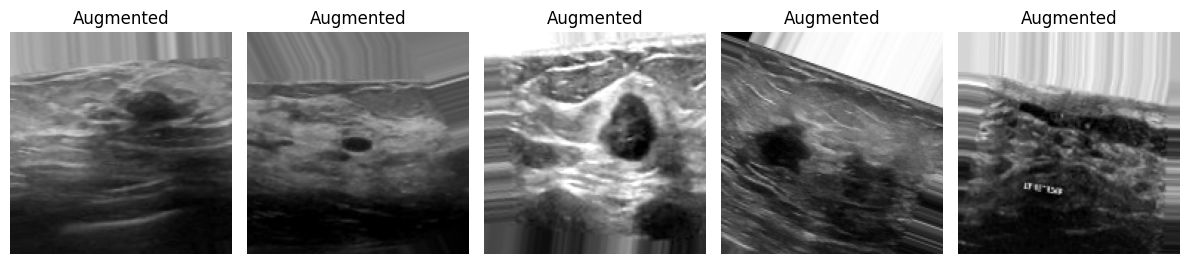

In [61]:
# Data Augmentation
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.6, 1.4],
    zoom_range=0.2,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment edilmiş örnekleri görselleştirmek için bir generator
preview_generator = aug_datagen.flow_from_directory(
    '/content/breast_ultrasound_split/train',
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

# Augment edilmiş ilk 5 örneğin gösterimi
plt.figure(figsize=(12, 6))
for i in range(5):
    img, label = next(preview_generator)
    plt.subplot(1, 5, i+1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.title("Augmented")
plt.tight_layout()
plt.show()


In [8]:
train_dir = '/content/breast_ultrasound_split/train'
augmented_dir = train_dir  # Augmentedı da aynı klasöre kaydediyorum

save_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

AUG_PER_IMAGE = 3

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png')) and 'mask' not in f.lower()]

    print(f"\n {class_name}: {len(images)} görüntü için augmenting...")

    for img_name in tqdm(images):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=(150, 150))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in save_aug.flow(x, batch_size=1, save_to_dir=class_path,
                                   save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= AUG_PER_IMAGE:
                break



 benign: 372 görüntü için augmenting...


100%|██████████| 372/372 [00:09<00:00, 38.57it/s]



 malignant: 179 görüntü için augmenting...


100%|██████████| 179/179 [00:04<00:00, 42.84it/s]



 normal: 114 görüntü için augmenting...


100%|██████████| 114/114 [00:02<00:00, 40.97it/s]


In [9]:
train_dir = '/content/breast_ultrasound_split/train'
total = 0

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"{class_name}: {len(images)} images")
    total += len(images)

print(f"\n Augmentationdan sonra toplam train verisi: {total}")


benign: 1445 images
malignant: 694 images
normal: 453 images

 Augmentationdan sonra toplam train verisi: 2592


In [10]:
print("Train Verisi:")
print("Toplam örnek sayısı:", train_generator.samples)
print("Sınıf sayısı:", train_generator.num_classes)
print("Sınıf indeksleri:", train_generator.class_indices)


Train Verisi:
Toplam örnek sayısı: 549
Sınıf sayısı: 3
Sınıf indeksleri: {'benign': 0, 'malignant': 1, 'normal': 2}


In [11]:
#CNN, VGG16 ve VGG19 modellerinin metrik gösteriminde kullanılacak fonksiyon
def evaluate_metrics(model, generator, set_name="SET", show_report=False):
    # Verinin gerçek classı
    y_true = generator.classes

    # Tahmin edilen olasılıkları
    y_pred_probs = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    y_true_oh = label_binarize(y_true, classes=[0, 1, 2])
    roc = roc_auc_score(y_true_oh, y_pred_probs, multi_class='ovr')

    print(f"\n {set_name.upper()} METRICS:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {roc:.4f}")

    # İstendiğinde görülebilmesi icin classification report ve confusion matrix
    if show_report:
        class_labels = list(generator.class_indices.keys())
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_labels))

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        disp.plot(cmap="Blues")
        plt.title(f"{set_name.upper()} Confusion Matrix")
        plt.show()


### CNN MODEL 1


In [55]:
img_size = (150, 150)
batch_size = 32
data_path = "/content/breast_ultrasound_split"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_path + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_path + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Found 2075 images belonging to 3 classes.
Found 517 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 75, 75, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 37, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 18, 18, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │              

 Total params: 1,819,011 (6.94 MB)

 Trainable params: 1,817,091 (6.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [56]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - accuracy: 0.5358 - loss: 1.0538 - val_accuracy: 0.2669 - val_loss: 1.3096
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.6330 - loss: 0.8400 - val_accuracy: 0.2669 - val_loss: 1.7460
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 351ms/step - accuracy: 0.6400 - loss: 0.8092 - val_accuracy: 0.2669 - val_loss: 1.8295
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 322ms/step - accuracy: 0.6648 - loss: 0.7935 - val_accuracy: 0.2669 - val_loss: 1.9185
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.6725 - loss: 0.7574 - val_accuracy: 0.3172 - val_loss: 1.6533
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.7029 - loss: 0.6743 - val_accuracy: 0.4043 - val_loss: 1.5183
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.7370 - loss: 0.6733 - val_accuracy: 0.4410 - val_loss: 1.4266
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.7060 - loss: 0.6916 - val_accu

In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/breast_ultrasound_split/test",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 115 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



 CNN MODEL 1 METRICS:
Accuracy:  0.7217
Precision: 0.7022
Recall:    0.7717
F1-score:  0.7099
ROC AUC:   0.9036

🔬 Classification Report:
              precision    recall  f1-score   support

      benign       0.89      0.65      0.75        65
   malignant       0.73      0.77      0.75        31
      normal       0.49      0.89      0.63        19

    accuracy                           0.72       115
   macro avg       0.70      0.77      0.71       115
weighted avg       0.78      0.72      0.73       115



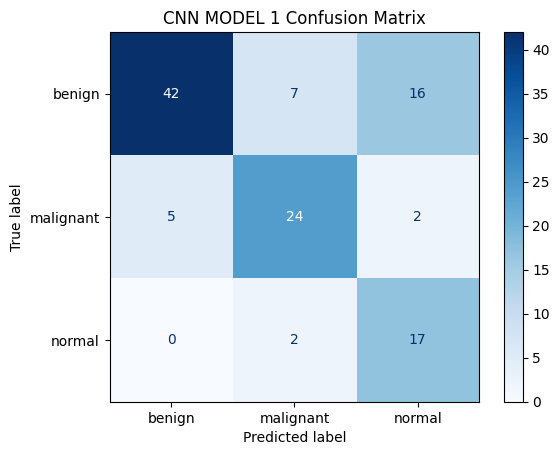

In [59]:
evaluate_metrics(model, test_generator, set_name="CNN Model 1", show_report=True)


###CNN MODEL 2



In [13]:
img_size = (150, 150)
batch_size = 32
data_path = "/content/breast_ultrasound_split/train"  # tek klasör (train)

# Validation split otomatik olarak (17.65%)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1765,  # otomatik ayırma
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Train Generator
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',   # otomatik train subset
    shuffle=True
)

# Validation Generator (sadece rescale uygulanır, augment yapılmaz)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1765)
val_generator = val_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # otomatik validation subset
    shuffle=False
)

# Model (LeakyReLU + Deeper Classifier)
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=7e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Found 2136 images belonging to 3 classes.
Found 456 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 74, 74, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 74, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 36, 36, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 36, 36, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 36, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 17, 17, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 17, 17, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 17, 17, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 1,949,571 (7.44 MB)

 Trainable params: 1,947,651 (7.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)
model.save("cnn_classic.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.5069 - loss: 1.1822 - val_accuracy: 0.2675 - val_loss: 1.2779
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - accuracy: 0.5739 - loss: 0.9550 - val_accuracy: 0.2675 - val_loss: 1.3677
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.6249 - loss: 0.8845 - val_accuracy: 0.2675 - val_loss: 1.4988
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.6230 - loss: 0.8671 - val_accuracy: 0.2675 - val_loss: 1.4096
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.6195 - loss: 0.8311 - val_accuracy: 0.2785 - val_loss: 1.2914
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.6554 - loss: 0.7991 - val_accuracy: 0.4583 - val_loss: 1.0642
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 272ms/step - accuracy: 0.6803 - loss: 0.7505 - val_accuracy: 0.5877 - val_loss: 0.9176
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - accuracy: 0.6696 - loss: 0.7641 - val_accu

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/breast_ultrasound_split/test",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 115 images belonging to 3 classes.



 CNN MODEL 2 METRICS:
Accuracy:  0.7913
Precision: 0.8542
Recall:    0.7124
F1-score:  0.7469
ROC AUC:   0.9230

🔬 Classification Report:
              precision    recall  f1-score   support

      benign       0.75      0.97      0.85        65
   malignant       1.00      0.48      0.65        31
      normal       0.81      0.68      0.74        19

    accuracy                           0.79       115
   macro avg       0.85      0.71      0.75       115
weighted avg       0.83      0.79      0.78       115



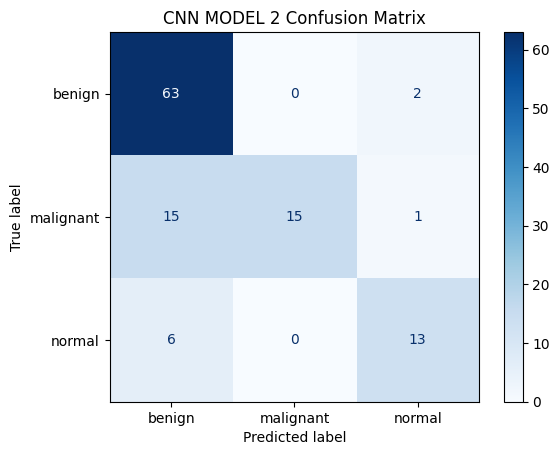

In [16]:
evaluate_metrics(model, test_generator, set_name="CNN Model 2", show_report=True)

 ### CNN Model 3


In [18]:
img_size = (150, 150)
batch_size = 32
data_path = "/content/breast_ultrasound_split/train"

# Otomatik Validation Split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1765,  # yaklaşık %17.65 validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator (augmentasyon yok, sadece rescale)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1765)
val_generator = val_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Model (Balanced Depth + LeakyReLU + Dropout + Focal Loss)
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(150, 150, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

optimizer = Adam(learning_rate=7e-5)
model.compile(
    optimizer=optimizer,
    loss=focal_loss(alpha=0.75, gamma=2.0),
    metrics=['accuracy']
)

model.summary()


Found 2136 images belonging to 3 classes.
Found 456 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 150, 150, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 74, 74, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 74, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 36, 36, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 36, 36, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 36, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 17, 17, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 17, 17, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 17, 17, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │              

 Total params: 1,949,571 (7.44 MB)

 Trainable params: 1,947,651 (7.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.4660 - loss: 0.5810
Epoch 1: val_accuracy improved from -inf to 0.17325, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - accuracy: 0.4665 - loss: 0.5793 - val_accuracy: 0.1732 - val_loss: 0.4066
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5371 - loss: 0.3385
Epoch 2: val_accuracy improved from 0.17325 to 0.26754, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.5371 - loss: 0.3384 - val_accuracy: 0.2675 - val_loss: 0.3814
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5939 - loss: 0.2907
Epoch 3: val_accuracy did not improve from 0.26754
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.5935 - loss: 0.2909 - val_accuracy: 0.2675 - val_loss: 0.4389
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6015 - loss: 0.2818
Epoch 4: val_accuracy did not improve from 0.26754
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - accuracy: 0.6014 - loss: 0.2818 - val_accuracy: 0.2675 - val_loss: 0.4333
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6258 - loss: 0.2595
Epoch 5: val_accuracy improved from 0.26754 to 0.53728, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.6259 - loss: 0.2594 - val_accuracy: 0.5373 - val_loss: 0.4238
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6408 - loss: 0.2518
Epoch 6: val_accuracy did not improve from 0.53728
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.6409 - loss: 0.2518 - val_accuracy: 0.5307 - val_loss: 0.4566
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6399 - loss: 0.2454
Epoch 7: val_accuracy did not improve from 0.53728
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 273ms/step - accuracy: 0.6399 - loss: 0.2455 - val_accuracy: 0.5000 - val_loss: 0.4295
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6666 - loss: 0.2283
Epoch 8: val_accuracy improved from 0.53728 to 0.60088, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.6666 - loss: 0.2283 - val_accuracy: 0.6009 - val_loss: 0.2950
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6559 - loss: 0.2265
Epoch 9: val_accuracy improved from 0.60088 to 0.62281, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 272ms/step - accuracy: 0.6559 - loss: 0.2265 - val_accuracy: 0.6228 - val_loss: 0.2315
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7087 - loss: 0.2137
Epoch 10: val_accuracy improved from 0.62281 to 0.70175, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 275ms/step - accuracy: 0.7085 - loss: 0.2137 - val_accuracy: 0.7018 - val_loss: 0.1980
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6767 - loss: 0.2214
Epoch 11: val_accuracy improved from 0.70175 to 0.74342, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - accuracy: 0.6769 - loss: 0.2214 - val_accuracy: 0.7434 - val_loss: 0.1994
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6969 - loss: 0.2055
Epoch 12: val_accuracy did not improve from 0.74342
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 0.6969 - loss: 0.2057 - val_accuracy: 0.6798 - val_loss: 0.2117
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6774 - loss: 0.2160
Epoch 13: val_accuracy improved from 0.74342 to 0.75658, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.6775 - loss: 0.2160 - val_accuracy: 0.7566 - val_loss: 0.1607
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6903 - loss: 0.2095
Epoch 14: val_accuracy did not improve from 0.75658
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.6903 - loss: 0.2095 - val_accuracy: 0.7193 - val_loss: 0.2054
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7171 - loss: 0.1928
Epoch 15: val_accuracy did not improve from 0.75658
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - accuracy: 0.7170 - loss: 0.1928 - val_accuracy: 0.7456 - val_loss: 0.1664
Epoch 16/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7207 - loss: 0.1927
Epoch 16: val_accuracy did not improve from 0.75658
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.7206 - loss: 0.1927 - val_accuracy: 0.6974 - val_loss: 0.2955
Epoch 17/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7311 - loss: 0.1930
Epoch 17: val_accuracy d

67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - accuracy: 0.7509 - loss: 0.1653 - val_accuracy: 0.7873 - val_loss: 0.1377
Epoch 33/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7352 - loss: 0.1695
Epoch 33: val_accuracy improved from 0.78728 to 0.79386, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.7353 - loss: 0.1695 - val_accuracy: 0.7939 - val_loss: 0.1533
Epoch 34/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7411 - loss: 0.1654
Epoch 34: val_accuracy did not improve from 0.79386
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.7412 - loss: 0.1655 - val_accuracy: 0.7807 - val_loss: 0.1384
Epoch 35/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7532 - loss: 0.1701
Epoch 35: val_accuracy did not improve from 0.79386
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.7533 - loss: 0.1701 - val_accuracy: 0.7785 - val_loss: 0.1351
Epoch 36/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7532 - loss: 0.1644
Epoch 36: val_accuracy improved from 0.79386 to 0.80044, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - accuracy: 0.7533 - loss: 0.1644 - val_accuracy: 0.8004 - val_loss: 0.1264
Epoch 37/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7561 - loss: 0.1575
Epoch 37: val_accuracy did not improve from 0.80044
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.7561 - loss: 0.1575 - val_accuracy: 0.7588 - val_loss: 0.1631
Epoch 38/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7524 - loss: 0.1622
Epoch 38: val_accuracy did not improve from 0.80044
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - accuracy: 0.7523 - loss: 0.1622 - val_accuracy: 0.7478 - val_loss: 0.1899
Epoch 39/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7555 - loss: 0.1576
Epoch 39: val_accuracy improved from 0.80044 to 0.80263, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.7556 - loss: 0.1576 - val_accuracy: 0.8026 - val_loss: 0.1326
Epoch 40/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7451 - loss: 0.1649
Epoch 40: val_accuracy did not improve from 0.80263
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 277ms/step - accuracy: 0.7451 - loss: 0.1649 - val_accuracy: 0.7390 - val_loss: 0.1591
Epoch 41/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7572 - loss: 0.1554
Epoch 41: val_accuracy improved from 0.80263 to 0.81579, saving model to best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.7572 - loss: 0.1554 - val_accuracy: 0.8158 - val_loss: 0.1233
Epoch 42/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.7644 - loss: 0.1533
Epoch 42: val_accuracy did not improve from 0.81579
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - accuracy: 0.7643 - loss: 0.1533 - val_accuracy: 0.7500 - val_loss: 0.1882
Epoch 43/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7777 - loss: 0.1472
Epoch 43: val_accuracy did not improve from 0.81579
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.7775 - loss: 0.1473 - val_accuracy: 0.7237 - val_loss: 0.1925
Epoch 44/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7769 - loss: 0.1499
Epoch 44: val_accuracy did not improve from 0.81579
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - accuracy: 0.7768 - loss: 0.1499 - val_accuracy: 0.7675 - val_loss: 0.1389
Epoch 45/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7662 - loss: 0.1488
Epoch 45: val_accuracy d

67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - accuracy: 0.7897 - loss: 0.1405 - val_accuracy: 0.8377 - val_loss: 0.1033


Found 115 images belonging to 3 classes.

 CNN METRICS:
Accuracy:  0.7739
Precision: 0.7444
Recall:    0.7776
F1-score:  0.7562
ROC AUC:   0.9187

🔬 Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.77      0.80        65
   malignant       0.80      0.77      0.79        31
      normal       0.60      0.79      0.68        19

    accuracy                           0.77       115
   macro avg       0.74      0.78      0.76       115
weighted avg       0.79      0.77      0.78       115



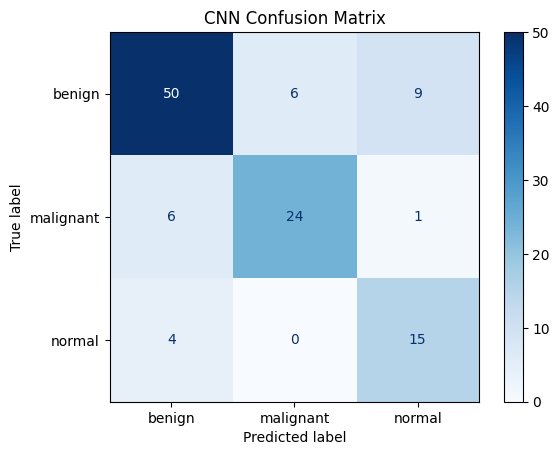

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/breast_ultrasound_split/test",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

evaluate_metrics(model, test_generator, set_name="CNN", show_report=True)

In [23]:
model = load_model("best_model_CNN.h5", custom_objects={"loss": focal_loss(alpha=0.75, gamma=2.0)})

model.compile(
    optimizer=Adam(learning_rate=7e-5),
    loss=focal_loss(alpha=0.75, gamma=2.0),
    metrics=["accuracy"]
)



 CLASSIC CNN FINE-TUNED METRICS:
Accuracy:  0.8000
Precision: 0.8008
Recall:    0.7569
F1-score:  0.7750
ROC AUC:   0.9057

🔬 Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.88      0.85        65
   malignant       0.71      0.71      0.71        31
      normal       0.87      0.68      0.76        19

    accuracy                           0.80       115
   macro avg       0.80      0.76      0.78       115
weighted avg       0.80      0.80      0.80       115



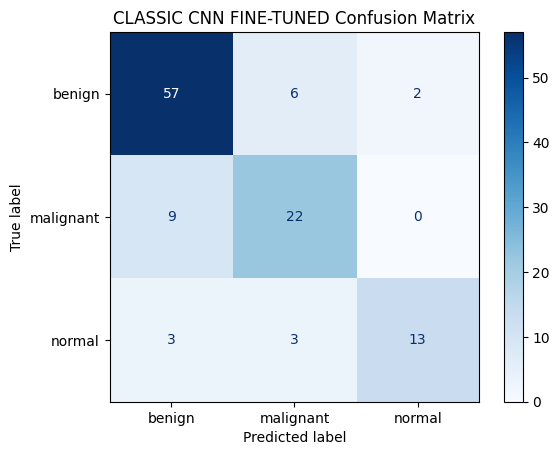

In [24]:
evaluate_metrics(model, test_generator, set_name="Classic CNN Fine-tuned", show_report=True)


Saving malignant (93).png to malignant (93) (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
🧠 Tahmin Edilen Sınıf: malignant
🔢 Güven: 68.57%


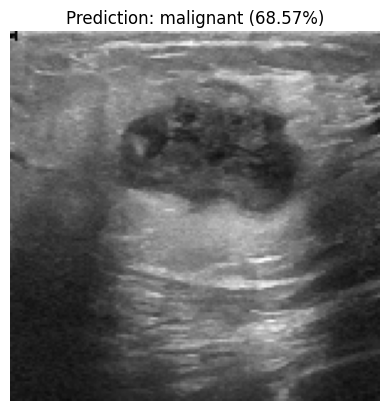

In [66]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5', custom_objects={'loss': focal_loss(alpha=0.75, gamma=2.0)})

# test icin görsel yükleme
from google.colab import files
uploaded = files.upload()

img_path = list(uploaded.keys())[0]

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# 5. Tahmin yap
pred = model.predict(img_array)
predicted_class_index = np.argmax(pred)

# 6. Sınıf isimlerini train_generator'dan al
class_labels = list(train_generator.class_indices.keys())

# 7. Sonuçları yazdır ve görselleştir
print("🧠 Tahmin Edilen Sınıf:", class_labels[predicted_class_index])
print("🔢 Güven: %.2f%%" % (pred[0][predicted_class_index] * 100))

plt.imshow(img)
plt.title(f"Prediction: {class_labels[predicted_class_index]} ({pred[0][predicted_class_index]*100:.2f}%)")
plt.axis("off")
plt.show()


###VGG16 Model

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


def focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# ✅ Parameters
img_size = (224, 224)
batch_size = 32
train_dir = "/content/breast_ultrasound_split/train"  # tek klasör (train)

# ✅ Data Generators (otomatik validation split)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.1765,  # ≈%17.65 validation için ayrılacak
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.1765)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    "/content/breast_ultrasound_split/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Fine-Tuned VGG16 Model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = True
for layer in vgg_base.layers[:-8]:
    layer.trainable = False

model_vgg16 = Sequential([
    vgg_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(alpha=0.75, gamma=2.0),
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    "vgg16_best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint]
)


Found 2136 images belonging to 3 classes.
Found 456 images belonging to 3 classes.
Found 115 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.3888 - loss: 0.5182
Epoch 1: val_accuracy improved from -inf to 0.63377, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 857ms/step - accuracy: 0.3896 - loss: 0.5169 - val_accuracy: 0.6338 - val_loss: 0.2701
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5086 - loss: 0.3375
Epoch 2: val_accuracy improved from 0.63377 to 0.65132, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 552ms/step - accuracy: 0.5092 - loss: 0.3371 - val_accuracy: 0.6513 - val_loss: 0.2188
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.6285 - loss: 0.2574
Epoch 3: val_accuracy improved from 0.65132 to 0.76096, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 568ms/step - accuracy: 0.6286 - loss: 0.2573 - val_accuracy: 0.7610 - val_loss: 0.1709
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6687 - loss: 0.2215
Epoch 4: val_accuracy did not improve from 0.76096
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 542ms/step - accuracy: 0.6689 - loss: 0.2214 - val_accuracy: 0.7566 - val_loss: 0.1580
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7263 - loss: 0.1999
Epoch 5: val_accuracy improved from 0.76096 to 0.78509, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 555ms/step - accuracy: 0.7261 - loss: 0.1999 - val_accuracy: 0.7851 - val_loss: 0.1470
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.7338 - loss: 0.1832
Epoch 6: val_accuracy improved from 0.78509 to 0.82237, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 555ms/step - accuracy: 0.7339 - loss: 0.1831 - val_accuracy: 0.8224 - val_loss: 0.1258
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.7640 - loss: 0.1643
Epoch 7: val_accuracy improved from 0.82237 to 0.84211, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 560ms/step - accuracy: 0.7639 - loss: 0.1644 - val_accuracy: 0.8421 - val_loss: 0.1203
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7866 - loss: 0.1528
Epoch 8: val_accuracy improved from 0.84211 to 0.87061, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 553ms/step - accuracy: 0.7865 - loss: 0.1528 - val_accuracy: 0.8706 - val_loss: 0.1030
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7939 - loss: 0.1408
Epoch 9: val_accuracy did not improve from 0.87061
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - accuracy: 0.7938 - loss: 0.1408 - val_accuracy: 0.8553 - val_loss: 0.0934
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7992 - loss: 0.1350
Epoch 10: val_accuracy improved from 0.87061 to 0.88377, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 548ms/step - accuracy: 0.7992 - loss: 0.1349 - val_accuracy: 0.8838 - val_loss: 0.0882
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8222 - loss: 0.1251
Epoch 11: val_accuracy did not improve from 0.88377
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 544ms/step - accuracy: 0.8222 - loss: 0.1251 - val_accuracy: 0.8377 - val_loss: 0.1041
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8042 - loss: 0.1221
Epoch 12: val_accuracy improved from 0.88377 to 0.89254, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 551ms/step - accuracy: 0.8042 - loss: 0.1221 - val_accuracy: 0.8925 - val_loss: 0.0849
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8346 - loss: 0.1102
Epoch 13: val_accuracy improved from 0.89254 to 0.89474, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 552ms/step - accuracy: 0.8346 - loss: 0.1102 - val_accuracy: 0.8947 - val_loss: 0.0774
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8467 - loss: 0.0971
Epoch 14: val_accuracy did not improve from 0.89474
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 542ms/step - accuracy: 0.8467 - loss: 0.0972 - val_accuracy: 0.8553 - val_loss: 0.0925
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8249 - loss: 0.1125
Epoch 15: val_accuracy did not improve from 0.89474
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 539ms/step - accuracy: 0.8252 - loss: 0.1123 - val_accuracy: 0.8947 - val_loss: 0.0731
Epoch 16/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8703 - loss: 0.0906
Epoch 16: val_accuracy improved from 0.89474 to 0.93202, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 551ms/step - accuracy: 0.8701 - loss: 0.0906 - val_accuracy: 0.9320 - val_loss: 0.0540
Epoch 17/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8526 - loss: 0.0946
Epoch 17: val_accuracy improved from 0.93202 to 0.93421, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 549ms/step - accuracy: 0.8526 - loss: 0.0947 - val_accuracy: 0.9342 - val_loss: 0.0513
Epoch 18/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8667 - loss: 0.0887
Epoch 18: val_accuracy did not improve from 0.93421
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 544ms/step - accuracy: 0.8668 - loss: 0.0886 - val_accuracy: 0.9211 - val_loss: 0.0550
Epoch 19/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8773 - loss: 0.0808
Epoch 19: val_accuracy did not improve from 0.93421
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 542ms/step - accuracy: 0.8772 - loss: 0.0809 - val_accuracy: 0.9189 - val_loss: 0.0633
Epoch 20/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8863 - loss: 0.0821
Epoch 20: val_accuracy did not improve from 0.93421
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 540ms/step - accuracy: 0.8863 - loss: 0.0820 - val_accuracy: 0.9123 - val_loss: 0.0594
Epoch 21/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8868 - loss: 0.0811
Epoch 21: val_accuracy d

67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 543ms/step - accuracy: 0.9149 - loss: 0.0641 - val_accuracy: 0.9386 - val_loss: 0.0397
Epoch 24/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9049 - loss: 0.0712
Epoch 24: val_accuracy did not improve from 0.93860
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 541ms/step - accuracy: 0.9050 - loss: 0.0711 - val_accuracy: 0.9342 - val_loss: 0.0480
Epoch 25/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9104 - loss: 0.0604
Epoch 25: val_accuracy improved from 0.93860 to 0.94956, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 554ms/step - accuracy: 0.9103 - loss: 0.0605 - val_accuracy: 0.9496 - val_loss: 0.0428
Epoch 26/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9089 - loss: 0.0615
Epoch 26: val_accuracy did not improve from 0.94956
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 543ms/step - accuracy: 0.9088 - loss: 0.0616 - val_accuracy: 0.9474 - val_loss: 0.0439
Epoch 27/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9195 - loss: 0.0558
Epoch 27: val_accuracy did not improve from 0.94956
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 545ms/step - accuracy: 0.9195 - loss: 0.0558 - val_accuracy: 0.8882 - val_loss: 0.0650
Epoch 28/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9057 - loss: 0.0590
Epoch 28: val_accuracy improved from 0.94956 to 0.96491, saving model to vgg16_best_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 543ms/step - accuracy: 0.9057 - loss: 0.0590 - val_accuracy: 0.9649 - val_loss: 0.0261
Epoch 29/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9011 - loss: 0.0632
Epoch 29: val_accuracy did not improve from 0.96491
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 544ms/step - accuracy: 0.9012 - loss: 0.0632 - val_accuracy: 0.9539 - val_loss: 0.0378
Epoch 30/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9339 - loss: 0.0495
Epoch 30: val_accuracy did not improve from 0.96491
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 542ms/step - accuracy: 0.9337 - loss: 0.0495 - val_accuracy: 0.9232 - val_loss: 0.0463
Epoch 31/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9298 - loss: 0.0484
Epoch 31: val_accuracy did not improve from 0.96491
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 550ms/step - accuracy: 0.9298 - loss: 0.0483 - val_accuracy: 0.9627 - val_loss: 0.0274
Epoch 32/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9040 - loss: 0.0643
Epoch 32: val_accuracy d

67/67 ━━━━━━━━━━━━━━━━━━━━ 43s 640ms/step - accuracy: 0.9366 - loss: 0.0428 - val_accuracy: 0.9825 - val_loss: 0.0208
Epoch 39/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9572 - loss: 0.0330
Epoch 39: val_accuracy did not improve from 0.98246
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 594ms/step - accuracy: 0.9571 - loss: 0.0330 - val_accuracy: 0.9539 - val_loss: 0.0376
Epoch 40/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9508 - loss: 0.0306
Epoch 40: val_accuracy did not improve from 0.98246
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 538ms/step - accuracy: 0.9508 - loss: 0.0306 - val_accuracy: 0.9693 - val_loss: 0.0218
Epoch 41/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9459 - loss: 0.0327
Epoch 41: val_accuracy did not improve from 0.98246
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 545ms/step - accuracy: 0.9459 - loss: 0.0327 - val_accuracy: 0.9627 - val_loss: 0.0269
Epoch 42/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9371 - loss: 0.0423
Epoch 42: val_accuracy d

67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 551ms/step - accuracy: 0.9490 - loss: 0.0373 - val_accuracy: 0.9846 - val_loss: 0.0182
Epoch 47/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9436 - loss: 0.0418
Epoch 47: val_accuracy did not improve from 0.98465
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - accuracy: 0.9437 - loss: 0.0417 - val_accuracy: 0.9846 - val_loss: 0.0135
Epoch 48/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9478 - loss: 0.0351
Epoch 48: val_accuracy did not improve from 0.98465
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 559ms/step - accuracy: 0.9478 - loss: 0.0351 - val_accuracy: 0.9737 - val_loss: 0.0158
Epoch 49/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9516 - loss: 0.0330
Epoch 49: val_accuracy did not improve from 0.98465
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - accuracy: 0.9516 - loss: 0.0329 - val_accuracy: 0.9759 - val_loss: 0.0172
Epoch 50/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9501 - loss: 0.0367
Epoch 50: val_accuracy d


 VGG16 TEST METRICS:
Accuracy:  0.8609
Precision: 0.9045
Recall:    0.7985
F1-score:  0.8377
ROC AUC:   0.9628

🔬 Classification Report:
              precision    recall  f1-score   support

      benign       0.83      0.97      0.89        65
   malignant       0.88      0.74      0.81        31
      normal       1.00      0.68      0.81        19

    accuracy                           0.86       115
   macro avg       0.90      0.80      0.84       115
weighted avg       0.87      0.86      0.86       115



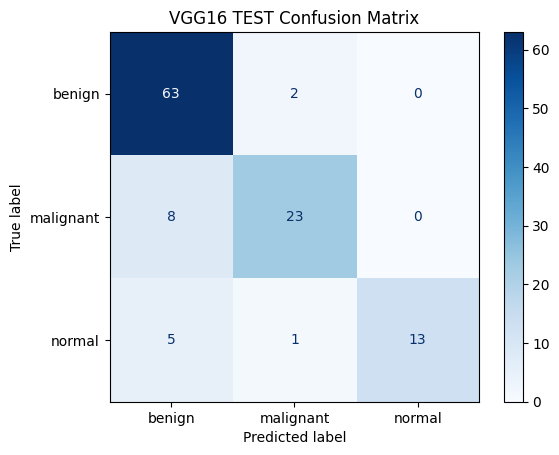

In [28]:
model_best = load_model("vgg16_best_model.h5", custom_objects={"loss": focal_loss(alpha=0.75, gamma=2.0)})

evaluate_metrics(model_best, test_generator, set_name="VGG16 TEST", show_report=True)

### ✅ VGG19 Model

In [29]:
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg19_base.trainable = True
for layer in vgg19_base.layers[:-8]:
    layer.trainable = False

model_vgg19 = Sequential([
    vgg19_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_vgg19.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(alpha=0.75, gamma=2.0),
    metrics=['accuracy']
)

model_vgg19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,156,483 (76.89 MB)

 Trainable params: 14,290,947 (54.52 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

In [30]:
history_vgg19 = model_vgg19.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 647ms/step - accuracy: 0.4505 - loss: 0.3989 - val_accuracy: 0.5943 - val_loss: 0.2898
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 576ms/step - accuracy: 0.5519 - loss: 0.3198 - val_accuracy: 0.6645 - val_loss: 0.2209
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 566ms/step - accuracy: 0.6407 - loss: 0.2484 - val_accuracy: 0.7522 - val_loss: 0.1911
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 571ms/step - accuracy: 0.6592 - loss: 0.2304 - val_accuracy: 0.7982 - val_loss: 0.1568
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 569ms/step - accuracy: 0.7196 - loss: 0.1981 - val_accuracy: 0.7412 - val_loss: 0.1647
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 562ms/step - accuracy: 0.7131 - loss: 0.1898 - val_accuracy: 0.7500 - val_loss: 0.1547
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 45s 617ms/step - accuracy: 0.7288 - loss: 0.1868 - val_accuracy: 0.8158 - val_loss: 0.1341
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 562ms/step - accuracy: 0.7671 - loss: 0.1639 - val_accu


 VGG19 TEST METRICS:
Accuracy:  0.8870
Precision: 0.9244
Recall:    0.8387
F1-score:  0.8727
ROC AUC:   0.9722

🔬 Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.98      0.91        65
   malignant       0.92      0.74      0.82        31
      normal       1.00      0.79      0.88        19

    accuracy                           0.89       115
   macro avg       0.92      0.84      0.87       115
weighted avg       0.90      0.89      0.88       115



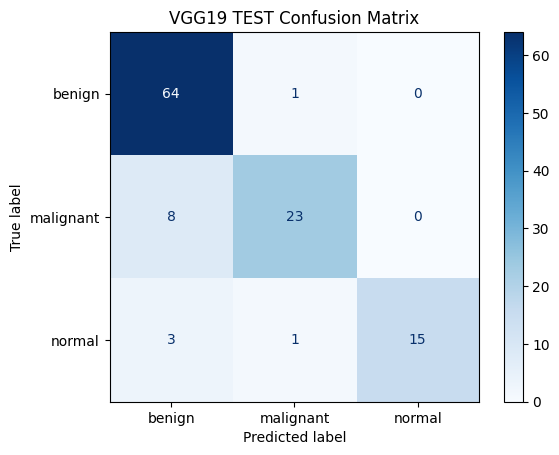

In [31]:
evaluate_metrics(model_vgg19, test_generator, set_name="VGG19 TEST", show_report=True)

Saving normal (8).png to normal (8) (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


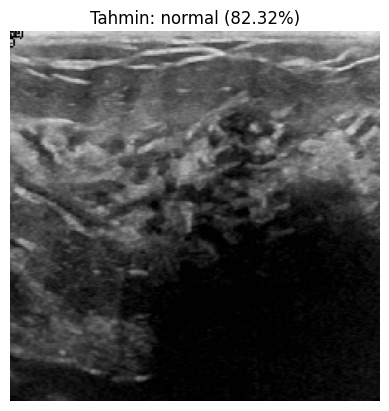

In [67]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()  # Bir veya daha fazla jpg, jpeg, png yüklenebilir

class_labels = list(train_generator.class_indices.keys())

for img_name in uploaded.keys():
    img = image.load_img(img_name, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model_vgg19.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class_index]
    confidence = prediction[0][predicted_class_index] * 100

    plt.figure()
    plt.imshow(img)
    plt.title(f"Tahmin: {predicted_label} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()


### ✅ SVM Using VGG16

In [32]:
dataset_path = "/content/breast_ultrasound_split"
img_size = (224, 224)

# Feature extraction için önceden eğitilmiş VGG16 modeli
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(directory):
    features = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if not os.path.isdir(class_dir):
            continue
        for img_name in tqdm(os.listdir(class_dir), desc=f"Extracting {label}"):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = image.load_img(img_path, target_size=img_size)
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)
                feature = vgg_model.predict(img_array)
                features.append(feature.flatten())
                labels.append(label)
            except:
                continue
    return np.array(features), np.array(labels)

# Hem train hem test setinden extraction yapılıyor
X_train_feat, y_train = extract_features(os.path.join(dataset_path, 'train'))
X_test_feat, y_test = extract_features(os.path.join(dataset_path, 'test'))

y_encoder = LabelEncoder()
y_train_enc = y_encoder.fit_transform(y_train)
y_test_enc = y_encoder.transform(y_test)

Extracting benign:   0%|          | 0/1445 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Extracting benign:   0%|          | 1/1445 [00:01<39:56,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting benign:   0%|          | 2/1445 [00:01<18:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting benign:   0%|          | 3/1445 [00:01<10:55,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting benign:   0%|          | 5/1445 [00:02<05:43,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting benign:   0%|          | 7/1445 [00:02<03:52,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting benign:   1%|          | 9/1445 [00:02<03:11,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting benign:   1%|          | 11/1445 [00:02<02:55,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting benign:   1%|          | 13/1445 [00:02<02:28,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting benign:   1%|          | 15/1445 [00:02<02:20, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting benign:   1%|          | 17/1445 [00:02<02:05, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting benign:   1%|▏         | 19/1445 [00:03<01:55, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Extracting benign:   1%|▏         | 21/1445 [00:03<01:51, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   2%|▏         | 23/1445 [00:03<01:56, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   2%|▏         | 25/1445 [00:03<02:03, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   2%|▏         | 27/1445 [00:03<01:57, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:   2%|▏         | 29/1445 [00:03<02:00, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   2%|▏         | 31/1445 [00:04<02:02, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   2%|▏         | 33/1445 [00:04<02:11, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:   2%|▏         | 35/1445 [00:04<02:21,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:   3%|▎         | 37/1445 [00:04<02:35,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:   3%|▎         | 38/1445 [00:04<02:39,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:   3%|▎         | 39/1445 [00:05<02:43,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:   3%|▎         | 40/1445 [00:05<02:38,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:   3%|▎         | 41/1445 [00:05<02:48,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:   3%|▎         | 42/1445 [00:05<02:42,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:   3%|▎         | 43/1445 [00:05<02:48,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:   3%|▎         | 45/1445 [00:05<02:43,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:   3%|▎         | 46/1445 [00:05<02:41,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:   3%|▎         | 47/1445 [00:06<02:44,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:   3%|▎         | 48/1445 [00:06<02:54,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:   3%|▎         | 49/1445 [00:06<02:56,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:   3%|▎         | 50/1445 [00:06<02:57,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   4%|▎         | 52/1445 [00:06<02:25,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:   4%|▎         | 53/1445 [00:06<02:27,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   4%|▎         | 54/1445 [00:06<02:27,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:   4%|▍         | 56/1445 [00:07<02:22,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:   4%|▍         | 58/1445 [00:07<02:16, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   4%|▍         | 60/1445 [00:07<02:15, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:   4%|▍         | 62/1445 [00:07<02:20,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   4%|▍         | 64/1445 [00:07<02:10, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   5%|▍         | 66/1445 [00:07<02:09, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   5%|▍         | 68/1445 [00:08<02:08, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   5%|▍         | 70/1445 [00:08<02:06, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   5%|▍         | 72/1445 [00:08<02:00, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   5%|▌         | 74/1445 [00:08<01:55, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   5%|▌         | 76/1445 [00:08<01:57, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:   5%|▌         | 78/1445 [00:08<01:58, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   6%|▌         | 80/1445 [00:09<01:58, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   6%|▌         | 82/1445 [00:09<01:52, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   6%|▌         | 84/1445 [00:09<02:01, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:   6%|▌         | 86/1445 [00:09<02:03, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   6%|▌         | 88/1445 [00:09<01:58, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   6%|▌         | 90/1445 [00:10<02:00, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   6%|▋         | 92/1445 [00:10<01:59, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:   7%|▋         | 94/1445 [00:10<02:07, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   7%|▋         | 96/1445 [00:10<02:04, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   7%|▋         | 98/1445 [00:10<02:05, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   7%|▋         | 100/1445 [00:10<02:00, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   7%|▋         | 102/1445 [00:11<01:54, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:   7%|▋         | 104/1445 [00:11<01:58, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:   7%|▋         | 106/1445 [00:11<02:07, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   7%|▋         | 108/1445 [00:11<02:10, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   8%|▊         | 110/1445 [00:11<02:01, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   8%|▊         | 112/1445 [00:12<02:08, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   8%|▊         | 114/1445 [00:12<02:00, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:   8%|▊         | 116/1445 [00:12<02:05, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   8%|▊         | 118/1445 [00:12<02:10, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   8%|▊         | 120/1445 [00:12<02:13,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:   8%|▊         | 122/1445 [00:13<02:11, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   9%|▊         | 124/1445 [00:13<02:11, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:   9%|▊         | 126/1445 [00:13<02:03, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   9%|▉         | 128/1445 [00:13<02:04, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:   9%|▉         | 130/1445 [00:13<01:59, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:   9%|▉         | 132/1445 [00:13<01:59, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   9%|▉         | 134/1445 [00:14<01:54, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:   9%|▉         | 136/1445 [00:14<01:51, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  10%|▉         | 138/1445 [00:14<01:49, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  10%|▉         | 140/1445 [00:14<01:54, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  10%|▉         | 142/1445 [00:14<01:56, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  10%|▉         | 144/1445 [00:15<01:52, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  10%|█         | 146/1445 [00:15<01:54, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  10%|█         | 148/1445 [00:15<01:51, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  10%|█         | 150/1445 [00:15<01:53, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  11%|█         | 152/1445 [00:15<01:55, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  11%|█         | 154/1445 [00:15<01:56, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  11%|█         | 156/1445 [00:16<02:03, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  11%|█         | 158/1445 [00:16<02:04, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  11%|█         | 160/1445 [00:16<02:02, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  11%|█         | 162/1445 [00:16<02:15,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  11%|█▏        | 163/1445 [00:16<02:19,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  11%|█▏        | 164/1445 [00:17<02:23,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  11%|█▏        | 165/1445 [00:17<02:26,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  11%|█▏        | 166/1445 [00:17<02:24,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  12%|█▏        | 168/1445 [00:17<02:21,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  12%|█▏        | 169/1445 [00:17<02:26,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  12%|█▏        | 170/1445 [00:17<02:29,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  12%|█▏        | 171/1445 [00:17<02:32,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  12%|█▏        | 172/1445 [00:17<02:36,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  12%|█▏        | 173/1445 [00:18<02:36,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  12%|█▏        | 174/1445 [00:18<02:40,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  12%|█▏        | 175/1445 [00:18<02:45,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  12%|█▏        | 176/1445 [00:18<02:47,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  12%|█▏        | 178/1445 [00:18<02:26,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  12%|█▏        | 180/1445 [00:18<02:13,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  13%|█▎        | 181/1445 [00:18<02:13,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  13%|█▎        | 182/1445 [00:19<02:16,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  13%|█▎        | 184/1445 [00:19<02:10,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  13%|█▎        | 186/1445 [00:19<01:59, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  13%|█▎        | 188/1445 [00:19<01:52, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  13%|█▎        | 190/1445 [00:19<01:55, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Extracting benign:  13%|█▎        | 192/1445 [00:19<01:49, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  13%|█▎        | 194/1445 [00:20<01:54, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  14%|█▎        | 196/1445 [00:20<01:59, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  14%|█▎        | 198/1445 [00:20<01:59, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  14%|█▍        | 200/1445 [00:20<01:53, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  14%|█▍        | 202/1445 [00:20<01:48, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  14%|█▍        | 204/1445 [00:21<01:51, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  14%|█▍        | 206/1445 [00:21<01:46, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  14%|█▍        | 208/1445 [00:21<01:54, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  15%|█▍        | 210/1445 [00:21<01:54, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  15%|█▍        | 212/1445 [00:21<02:01, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  15%|█▍        | 214/1445 [00:22<02:04,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  15%|█▍        | 216/1445 [00:22<02:05,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  15%|█▌        | 217/1445 [00:22<02:07,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  15%|█▌        | 219/1445 [00:22<02:03,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  15%|█▌        | 221/1445 [00:22<01:54, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  15%|█▌        | 223/1445 [00:22<01:54, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  16%|█▌        | 225/1445 [00:23<01:53, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  16%|█▌        | 227/1445 [00:23<01:47, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  16%|█▌        | 229/1445 [00:23<01:48, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  16%|█▌        | 231/1445 [00:23<01:44, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  16%|█▌        | 233/1445 [00:23<01:53, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  16%|█▋        | 235/1445 [00:24<01:52, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  16%|█▋        | 237/1445 [00:24<01:53, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  17%|█▋        | 239/1445 [00:24<01:48, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  17%|█▋        | 241/1445 [00:24<01:54, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  17%|█▋        | 243/1445 [00:24<01:59, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  17%|█▋        | 245/1445 [00:24<01:53, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  17%|█▋        | 247/1445 [00:25<01:52, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  17%|█▋        | 249/1445 [00:25<01:54, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  17%|█▋        | 251/1445 [00:25<01:59,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  18%|█▊        | 253/1445 [00:25<01:52, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  18%|█▊        | 255/1445 [00:25<01:53, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  18%|█▊        | 257/1445 [00:26<01:52, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  18%|█▊        | 259/1445 [00:26<01:52, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  18%|█▊        | 261/1445 [00:26<01:51, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  18%|█▊        | 263/1445 [00:26<01:46, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  18%|█▊        | 265/1445 [00:26<01:54, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  18%|█▊        | 267/1445 [00:27<01:53, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  19%|█▊        | 269/1445 [00:27<01:51, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  19%|█▉        | 271/1445 [00:27<01:55, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  19%|█▉        | 273/1445 [00:27<01:47, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  19%|█▉        | 275/1445 [00:27<01:51, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  19%|█▉        | 277/1445 [00:27<01:46, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  19%|█▉        | 279/1445 [00:28<01:53, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  19%|█▉        | 281/1445 [00:28<01:45, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  20%|█▉        | 283/1445 [00:28<01:49, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  20%|█▉        | 285/1445 [00:28<01:58,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  20%|█▉        | 287/1445 [00:29<02:04,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  20%|█▉        | 288/1445 [00:29<02:07,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  20%|██        | 289/1445 [00:29<02:06,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  20%|██        | 290/1445 [00:29<02:09,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  20%|██        | 291/1445 [00:29<02:12,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  20%|██        | 292/1445 [00:29<02:08,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  20%|██        | 293/1445 [00:29<02:17,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  20%|██        | 294/1445 [00:29<02:21,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  20%|██        | 295/1445 [00:30<02:19,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  20%|██        | 296/1445 [00:30<02:23,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  21%|██        | 297/1445 [00:30<02:26,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  21%|██        | 298/1445 [00:30<02:29,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  21%|██        | 299/1445 [00:30<02:31,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  21%|██        | 300/1445 [00:30<02:24,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  21%|██        | 302/1445 [00:30<02:00,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  21%|██        | 303/1445 [00:30<02:03,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  21%|██        | 304/1445 [00:31<02:04,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  21%|██        | 305/1445 [00:31<02:10,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  21%|██        | 307/1445 [00:31<01:59,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  21%|██▏       | 309/1445 [00:31<01:46, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  22%|██▏       | 311/1445 [00:31<01:46, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  22%|██▏       | 313/1445 [00:31<01:45, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  22%|██▏       | 315/1445 [00:32<01:41, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  22%|██▏       | 317/1445 [00:32<01:42, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  22%|██▏       | 319/1445 [00:32<01:42, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  22%|██▏       | 321/1445 [00:32<01:42, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  22%|██▏       | 323/1445 [00:32<01:43, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  22%|██▏       | 325/1445 [00:33<01:49, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  23%|██▎       | 327/1445 [00:33<01:53,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  23%|██▎       | 328/1445 [00:33<01:56,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  23%|██▎       | 330/1445 [00:33<01:46, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  23%|██▎       | 332/1445 [00:33<01:45, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  23%|██▎       | 334/1445 [00:33<01:44, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  23%|██▎       | 336/1445 [00:34<01:44, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  23%|██▎       | 338/1445 [00:34<01:45, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  24%|██▎       | 340/1445 [00:34<01:46, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  24%|██▎       | 342/1445 [00:34<01:44, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  24%|██▍       | 344/1445 [00:34<01:42, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  24%|██▍       | 346/1445 [00:34<01:38, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  24%|██▍       | 348/1445 [00:35<01:36, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  24%|██▍       | 350/1445 [00:35<01:37, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  24%|██▍       | 352/1445 [00:35<01:39, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  24%|██▍       | 354/1445 [00:35<01:45, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  25%|██▍       | 356/1445 [00:35<01:44, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  25%|██▍       | 358/1445 [00:36<01:47, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  25%|██▍       | 360/1445 [00:36<01:40, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  25%|██▌       | 362/1445 [00:36<01:37, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  25%|██▌       | 364/1445 [00:36<01:35, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  25%|██▌       | 366/1445 [00:36<01:38, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  25%|██▌       | 368/1445 [00:37<01:39, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  26%|██▌       | 370/1445 [00:37<01:45, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  26%|██▌       | 372/1445 [00:37<01:45, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  26%|██▌       | 374/1445 [00:37<01:40, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  26%|██▌       | 376/1445 [00:37<01:45, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  26%|██▌       | 378/1445 [00:38<01:43, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  26%|██▋       | 380/1445 [00:38<01:44, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  26%|██▋       | 382/1445 [00:38<01:48,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  27%|██▋       | 384/1445 [00:38<01:46,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  27%|██▋       | 386/1445 [00:38<01:43, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  27%|██▋       | 388/1445 [00:39<01:41, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  27%|██▋       | 390/1445 [00:39<01:46,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  27%|██▋       | 392/1445 [00:39<01:43, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  27%|██▋       | 394/1445 [00:39<01:37, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Extracting benign:  27%|██▋       | 396/1445 [00:39<01:31, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  28%|██▊       | 398/1445 [00:39<01:37, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  28%|██▊       | 400/1445 [00:40<01:37, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  28%|██▊       | 402/1445 [00:40<01:42, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  28%|██▊       | 404/1445 [00:40<01:41, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  28%|██▊       | 406/1445 [00:40<01:46,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  28%|██▊       | 407/1445 [00:40<01:50,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  28%|██▊       | 408/1445 [00:41<01:56,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  28%|██▊       | 409/1445 [00:41<02:01,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  28%|██▊       | 410/1445 [00:41<02:04,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  28%|██▊       | 411/1445 [00:41<02:02,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  29%|██▊       | 412/1445 [00:41<01:58,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  29%|██▊       | 413/1445 [00:41<02:01,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  29%|██▊       | 414/1445 [00:41<01:58,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  29%|██▊       | 415/1445 [00:41<01:56,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  29%|██▉       | 416/1445 [00:41<02:00,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  29%|██▉       | 417/1445 [00:42<02:05,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  29%|██▉       | 418/1445 [00:42<02:06,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  29%|██▉       | 419/1445 [00:42<02:11,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  29%|██▉       | 420/1445 [00:42<02:10,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  29%|██▉       | 421/1445 [00:42<02:15,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  29%|██▉       | 422/1445 [00:42<02:11,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  29%|██▉       | 424/1445 [00:42<01:55,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  29%|██▉       | 426/1445 [00:43<01:49,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  30%|██▉       | 427/1445 [00:43<01:50,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  30%|██▉       | 429/1445 [00:43<01:39, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  30%|██▉       | 431/1445 [00:43<01:38, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  30%|██▉       | 433/1445 [00:43<01:37, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  30%|███       | 435/1445 [00:43<01:31, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  30%|███       | 437/1445 [00:44<01:33, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  30%|███       | 439/1445 [00:44<01:37, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  31%|███       | 441/1445 [00:44<01:31, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  31%|███       | 443/1445 [00:44<01:36, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  31%|███       | 445/1445 [00:44<01:35, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  31%|███       | 447/1445 [00:45<01:39, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  31%|███       | 449/1445 [00:45<01:38, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  31%|███       | 451/1445 [00:45<01:36, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  31%|███▏      | 453/1445 [00:45<01:30, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  31%|███▏      | 455/1445 [00:45<01:34, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  32%|███▏      | 457/1445 [00:46<01:38, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  32%|███▏      | 459/1445 [00:46<01:40,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  32%|███▏      | 461/1445 [00:46<01:39,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  32%|███▏      | 463/1445 [00:46<01:41,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  32%|███▏      | 465/1445 [00:46<01:38,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  32%|███▏      | 467/1445 [00:47<01:32, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  32%|███▏      | 469/1445 [00:47<01:33, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  33%|███▎      | 471/1445 [00:47<01:30, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  33%|███▎      | 473/1445 [00:47<01:31, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  33%|███▎      | 475/1445 [00:47<01:31, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  33%|███▎      | 477/1445 [00:48<01:30, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  33%|███▎      | 479/1445 [00:48<01:34, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  33%|███▎      | 481/1445 [00:48<01:30, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  33%|███▎      | 483/1445 [00:48<01:32, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  34%|███▎      | 485/1445 [00:48<01:32, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  34%|███▎      | 487/1445 [00:49<01:36,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  34%|███▍      | 489/1445 [00:49<01:36,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  34%|███▍      | 490/1445 [00:49<01:38,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  34%|███▍      | 491/1445 [00:49<01:42,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  34%|███▍      | 493/1445 [00:49<01:39,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  34%|███▍      | 495/1445 [00:49<01:36,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  34%|███▍      | 497/1445 [00:50<01:34, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  35%|███▍      | 499/1445 [00:50<01:30, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  35%|███▍      | 501/1445 [00:50<01:30, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  35%|███▍      | 503/1445 [00:50<01:31, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  35%|███▍      | 505/1445 [00:50<01:27, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  35%|███▌      | 507/1445 [00:51<01:32, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  35%|███▌      | 509/1445 [00:51<01:27, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  35%|███▌      | 511/1445 [00:51<01:27, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  36%|███▌      | 513/1445 [00:51<01:28, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  36%|███▌      | 515/1445 [00:51<01:31, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  36%|███▌      | 517/1445 [00:51<01:29, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  36%|███▌      | 519/1445 [00:52<01:25, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  36%|███▌      | 521/1445 [00:52<01:27, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  36%|███▌      | 523/1445 [00:52<01:31, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  36%|███▋      | 525/1445 [00:52<01:36,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  36%|███▋      | 527/1445 [00:53<01:39,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  37%|███▋      | 528/1445 [00:53<01:40,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  37%|███▋      | 529/1445 [00:53<01:45,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  37%|███▋      | 530/1445 [00:53<01:50,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  37%|███▋      | 531/1445 [00:53<01:52,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  37%|███▋      | 532/1445 [00:53<01:57,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  37%|███▋      | 533/1445 [00:53<01:50,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  37%|███▋      | 534/1445 [00:53<01:52,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  37%|███▋      | 535/1445 [00:54<01:47,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  37%|███▋      | 536/1445 [00:54<01:54,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  37%|███▋      | 537/1445 [00:54<01:55,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  37%|███▋      | 538/1445 [00:54<01:55,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting benign:  37%|███▋      | 539/1445 [00:54<01:59,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  37%|███▋      | 540/1445 [00:54<01:56,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  37%|███▋      | 541/1445 [00:54<02:05,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  38%|███▊      | 542/1445 [00:54<01:58,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  38%|███▊      | 543/1445 [00:55<01:53,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  38%|███▊      | 544/1445 [00:55<01:50,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  38%|███▊      | 546/1445 [00:55<01:40,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  38%|███▊      | 547/1445 [00:55<01:39,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  38%|███▊      | 549/1445 [00:55<01:35,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  38%|███▊      | 550/1445 [00:55<01:35,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  38%|███▊      | 552/1445 [00:55<01:30,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  38%|███▊      | 553/1445 [00:56<01:32,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  38%|███▊      | 555/1445 [00:56<01:24, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  39%|███▊      | 557/1445 [00:56<01:30,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  39%|███▊      | 558/1445 [00:56<01:32,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  39%|███▉      | 560/1445 [00:56<01:29,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Extracting benign:  39%|███▉      | 561/1445 [00:56<01:30,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  39%|███▉      | 562/1445 [00:57<01:32,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  39%|███▉      | 563/1445 [00:57<01:33,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  39%|███▉      | 564/1445 [00:57<01:35,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  39%|███▉      | 565/1445 [00:57<01:37,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  39%|███▉      | 566/1445 [00:57<01:36,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  39%|███▉      | 568/1445 [00:57<01:31,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  39%|███▉      | 569/1445 [00:57<01:32,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  39%|███▉      | 570/1445 [00:57<01:33,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  40%|███▉      | 571/1445 [00:57<01:34,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  40%|███▉      | 572/1445 [00:58<01:37,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  40%|███▉      | 574/1445 [00:58<01:25, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  40%|███▉      | 575/1445 [00:58<01:26, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  40%|███▉      | 576/1445 [00:58<01:28,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  40%|███▉      | 577/1445 [00:58<01:31,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  40%|████      | 578/1445 [00:58<01:34,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  40%|████      | 579/1445 [00:58<01:33,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  40%|████      | 581/1445 [00:59<01:28,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  40%|████      | 582/1445 [00:59<01:30,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  40%|████      | 583/1445 [00:59<01:30,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  40%|████      | 584/1445 [00:59<01:32,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  40%|████      | 585/1445 [00:59<01:32,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  41%|████      | 586/1445 [00:59<01:32,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  41%|████      | 587/1445 [00:59<01:32,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  41%|████      | 589/1445 [00:59<01:26,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  41%|████      | 590/1445 [00:59<01:30,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  41%|████      | 591/1445 [01:00<01:30,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  41%|████      | 592/1445 [01:00<01:32,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  41%|████      | 593/1445 [01:00<01:32,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  41%|████      | 594/1445 [01:00<01:32,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  41%|████      | 595/1445 [01:00<01:33,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  41%|████▏     | 597/1445 [01:00<01:29,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  41%|████▏     | 599/1445 [01:00<01:25,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  42%|████▏     | 600/1445 [01:01<01:26,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  42%|████▏     | 601/1445 [01:01<01:29,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  42%|████▏     | 602/1445 [01:01<01:30,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  42%|████▏     | 603/1445 [01:01<01:32,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  42%|████▏     | 604/1445 [01:01<01:33,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  42%|████▏     | 606/1445 [01:01<01:25,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  42%|████▏     | 607/1445 [01:01<01:30,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  42%|████▏     | 608/1445 [01:01<01:32,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  42%|████▏     | 609/1445 [01:02<01:33,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  42%|████▏     | 610/1445 [01:02<01:32,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  42%|████▏     | 611/1445 [01:02<01:34,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  42%|████▏     | 612/1445 [01:02<01:37,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  42%|████▏     | 613/1445 [01:02<01:37,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  42%|████▏     | 614/1445 [01:02<01:36,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  43%|████▎     | 616/1445 [01:02<01:27,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  43%|████▎     | 618/1445 [01:02<01:20, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  43%|████▎     | 620/1445 [01:03<01:24,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  43%|████▎     | 622/1445 [01:03<01:24,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  43%|████▎     | 623/1445 [01:03<01:25,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  43%|████▎     | 625/1445 [01:03<01:19, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  43%|████▎     | 627/1445 [01:03<01:20, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  44%|████▎     | 629/1445 [01:04<01:24,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  44%|████▎     | 631/1445 [01:04<01:22,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  44%|████▍     | 633/1445 [01:04<01:21,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  44%|████▍     | 634/1445 [01:04<01:22,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  44%|████▍     | 636/1445 [01:04<01:20, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting benign:  44%|████▍     | 638/1445 [01:05<01:27,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  44%|████▍     | 639/1445 [01:05<01:31,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  44%|████▍     | 640/1445 [01:05<01:34,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  44%|████▍     | 641/1445 [01:05<01:35,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  44%|████▍     | 642/1445 [01:05<01:36,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  44%|████▍     | 643/1445 [01:05<01:36,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting benign:  45%|████▍     | 644/1445 [01:05<01:39,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  45%|████▍     | 645/1445 [01:05<01:39,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  45%|████▍     | 646/1445 [01:06<01:36,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  45%|████▍     | 647/1445 [01:06<01:34,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  45%|████▍     | 648/1445 [01:06<01:38,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  45%|████▍     | 649/1445 [01:06<01:37,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  45%|████▍     | 650/1445 [01:06<01:39,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  45%|████▌     | 651/1445 [01:06<01:36,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  45%|████▌     | 652/1445 [01:06<01:45,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  45%|████▌     | 653/1445 [01:06<01:45,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  45%|████▌     | 654/1445 [01:07<01:48,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  45%|████▌     | 655/1445 [01:07<01:43,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  45%|████▌     | 657/1445 [01:07<01:26,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  46%|████▌     | 658/1445 [01:07<01:27,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  46%|████▌     | 659/1445 [01:07<01:26,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  46%|████▌     | 660/1445 [01:07<01:26,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  46%|████▌     | 661/1445 [01:07<01:27,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  46%|████▌     | 663/1445 [01:08<01:24,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  46%|████▌     | 664/1445 [01:08<01:25,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  46%|████▌     | 665/1445 [01:08<01:25,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  46%|████▌     | 667/1445 [01:08<01:21,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  46%|████▌     | 668/1445 [01:08<01:21,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  46%|████▋     | 669/1445 [01:08<01:23,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  46%|████▋     | 671/1445 [01:08<01:19,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  47%|████▋     | 673/1445 [01:09<01:18,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  47%|████▋     | 674/1445 [01:09<01:20,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  47%|████▋     | 675/1445 [01:09<01:21,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  47%|████▋     | 677/1445 [01:09<01:17,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  47%|████▋     | 679/1445 [01:09<01:11, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  47%|████▋     | 681/1445 [01:09<01:12, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  47%|████▋     | 683/1445 [01:10<01:10, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  47%|████▋     | 685/1445 [01:10<01:08, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  48%|████▊     | 687/1445 [01:10<01:14, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  48%|████▊     | 689/1445 [01:10<01:13, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  48%|████▊     | 691/1445 [01:10<01:17,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  48%|████▊     | 692/1445 [01:10<01:19,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  48%|████▊     | 693/1445 [01:11<01:20,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  48%|████▊     | 694/1445 [01:11<01:21,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  48%|████▊     | 696/1445 [01:11<01:12, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  48%|████▊     | 698/1445 [01:11<01:11, 10.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  48%|████▊     | 700/1445 [01:11<01:12, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  49%|████▊     | 702/1445 [01:11<01:16,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  49%|████▊     | 704/1445 [01:12<01:16,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  49%|████▉     | 705/1445 [01:12<01:18,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  49%|████▉     | 706/1445 [01:12<01:18,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  49%|████▉     | 708/1445 [01:12<01:17,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  49%|████▉     | 709/1445 [01:12<01:18,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  49%|████▉     | 711/1445 [01:12<01:13, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  49%|████▉     | 712/1445 [01:13<01:15,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  49%|████▉     | 713/1445 [01:13<01:18,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  49%|████▉     | 715/1445 [01:13<01:13,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  50%|████▉     | 716/1445 [01:13<01:15,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  50%|████▉     | 717/1445 [01:13<01:16,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  50%|████▉     | 718/1445 [01:13<01:19,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  50%|████▉     | 719/1445 [01:13<01:21,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  50%|████▉     | 720/1445 [01:13<01:23,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  50%|████▉     | 722/1445 [01:14<01:19,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  50%|█████     | 724/1445 [01:14<01:16,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  50%|█████     | 725/1445 [01:14<01:17,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  50%|█████     | 727/1445 [01:14<01:15,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  50%|█████     | 728/1445 [01:14<01:16,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  50%|█████     | 729/1445 [01:14<01:17,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  51%|█████     | 730/1445 [01:14<01:18,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  51%|█████     | 731/1445 [01:15<01:16,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  51%|█████     | 732/1445 [01:15<01:18,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  51%|█████     | 733/1445 [01:15<01:18,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  51%|█████     | 735/1445 [01:15<01:16,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  51%|█████     | 736/1445 [01:15<01:18,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  51%|█████     | 738/1445 [01:15<01:10, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  51%|█████     | 740/1445 [01:15<01:07, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  51%|█████▏    | 742/1445 [01:16<01:09, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  51%|█████▏    | 744/1445 [01:16<01:13,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  52%|█████▏    | 746/1445 [01:16<01:10,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  52%|█████▏    | 748/1445 [01:16<01:12,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  52%|█████▏    | 750/1445 [01:16<01:08, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  52%|█████▏    | 752/1445 [01:17<01:09,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  52%|█████▏    | 753/1445 [01:17<01:14,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  52%|█████▏    | 754/1445 [01:17<01:19,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  52%|█████▏    | 755/1445 [01:17<01:20,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  52%|█████▏    | 756/1445 [01:17<01:22,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting benign:  52%|█████▏    | 757/1445 [01:17<01:25,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  52%|█████▏    | 758/1445 [01:17<01:24,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  53%|█████▎    | 759/1445 [01:18<01:31,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  53%|█████▎    | 760/1445 [01:18<01:33,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  53%|█████▎    | 761/1445 [01:18<01:31,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  53%|█████▎    | 762/1445 [01:18<01:30,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  53%|█████▎    | 763/1445 [01:18<01:32,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  53%|█████▎    | 764/1445 [01:18<01:32,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  53%|█████▎    | 765/1445 [01:18<01:32,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  53%|█████▎    | 766/1445 [01:19<01:31,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting benign:  53%|█████▎    | 767/1445 [01:19<01:33,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  53%|█████▎    | 768/1445 [01:19<01:34,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  53%|█████▎    | 770/1445 [01:19<01:18,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  53%|█████▎    | 772/1445 [01:19<01:09,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  53%|█████▎    | 773/1445 [01:19<01:12,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  54%|█████▎    | 774/1445 [01:19<01:14,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  54%|█████▎    | 775/1445 [01:20<01:14,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  54%|█████▍    | 777/1445 [01:20<01:10,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  54%|█████▍    | 778/1445 [01:20<01:12,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Extracting benign:  54%|█████▍    | 780/1445 [01:20<01:09,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  54%|█████▍    | 782/1445 [01:20<01:05, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  54%|█████▍    | 784/1445 [01:20<01:02, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  54%|█████▍    | 786/1445 [01:21<01:03, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  55%|█████▍    | 788/1445 [01:21<01:04, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  55%|█████▍    | 790/1445 [01:21<01:07,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  55%|█████▍    | 791/1445 [01:21<01:08,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  55%|█████▍    | 792/1445 [01:21<01:10,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  55%|█████▍    | 794/1445 [01:22<01:09,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  55%|█████▌    | 795/1445 [01:22<01:10,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  55%|█████▌    | 796/1445 [01:22<01:11,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  55%|█████▌    | 797/1445 [01:22<01:13,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  55%|█████▌    | 799/1445 [01:22<01:05,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  55%|█████▌    | 801/1445 [01:22<01:05,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  56%|█████▌    | 802/1445 [01:22<01:07,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  56%|█████▌    | 803/1445 [01:22<01:09,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  56%|█████▌    | 804/1445 [01:23<01:11,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  56%|█████▌    | 806/1445 [01:23<01:05,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  56%|█████▌    | 807/1445 [01:23<01:08,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  56%|█████▌    | 808/1445 [01:23<01:09,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  56%|█████▌    | 809/1445 [01:23<01:11,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  56%|█████▌    | 810/1445 [01:23<01:13,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  56%|█████▌    | 811/1445 [01:23<01:12,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  56%|█████▌    | 812/1445 [01:24<01:13,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  56%|█████▋    | 814/1445 [01:24<01:04,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  56%|█████▋    | 815/1445 [01:24<01:06,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  57%|█████▋    | 817/1445 [01:24<01:04,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  57%|█████▋    | 819/1445 [01:24<01:37,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  57%|█████▋    | 821/1445 [01:25<01:22,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  57%|█████▋    | 823/1445 [01:25<01:16,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  57%|█████▋    | 824/1445 [01:25<01:16,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  57%|█████▋    | 825/1445 [01:25<01:15,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  57%|█████▋    | 827/1445 [01:25<01:07,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  57%|█████▋    | 829/1445 [01:25<01:02,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  58%|█████▊    | 831/1445 [01:26<01:03,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  58%|█████▊    | 832/1445 [01:26<01:04,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  58%|█████▊    | 833/1445 [01:26<01:06,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  58%|█████▊    | 835/1445 [01:26<01:04,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  58%|█████▊    | 837/1445 [01:26<01:00, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  58%|█████▊    | 839/1445 [01:27<01:01,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  58%|█████▊    | 840/1445 [01:27<01:02,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  58%|█████▊    | 841/1445 [01:27<01:04,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  58%|█████▊    | 842/1445 [01:27<01:04,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  58%|█████▊    | 843/1445 [01:27<01:06,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  58%|█████▊    | 845/1445 [01:27<01:03,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  59%|█████▊    | 847/1445 [01:27<01:02,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  59%|█████▊    | 848/1445 [01:27<01:03,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  59%|█████▉    | 850/1445 [01:28<00:59, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  59%|█████▉    | 851/1445 [01:28<01:00,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  59%|█████▉    | 852/1445 [01:28<01:01,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  59%|█████▉    | 853/1445 [01:28<01:03,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  59%|█████▉    | 854/1445 [01:28<01:04,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  59%|█████▉    | 855/1445 [01:28<01:11,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Extracting benign:  59%|█████▉    | 856/1445 [01:28<01:21,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  59%|█████▉    | 857/1445 [01:29<01:19,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  59%|█████▉    | 858/1445 [01:29<01:17,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  59%|█████▉    | 859/1445 [01:29<01:14,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  60%|█████▉    | 860/1445 [01:29<01:11,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting benign:  60%|█████▉    | 861/1445 [01:29<01:13,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  60%|█████▉    | 862/1445 [01:29<01:15,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  60%|█████▉    | 863/1445 [01:29<01:16,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  60%|█████▉    | 864/1445 [01:29<01:12,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting benign:  60%|█████▉    | 865/1445 [01:30<01:17,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  60%|█████▉    | 866/1445 [01:30<01:14,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  60%|██████    | 867/1445 [01:30<01:13,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  60%|██████    | 868/1445 [01:30<01:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting benign:  60%|██████    | 869/1445 [01:30<01:18,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  60%|██████    | 870/1445 [01:30<01:16,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  60%|██████    | 871/1445 [01:30<01:12,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  60%|██████    | 872/1445 [01:30<01:14,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting benign:  60%|██████    | 873/1445 [01:31<01:15,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  60%|██████    | 874/1445 [01:31<01:15,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting benign:  61%|██████    | 875/1445 [01:31<01:19,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  61%|██████    | 876/1445 [01:31<01:19,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  61%|██████    | 877/1445 [01:31<01:19,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  61%|██████    | 878/1445 [01:31<01:14,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  61%|██████    | 879/1445 [01:31<01:12,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  61%|██████    | 880/1445 [01:32<01:10,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  61%|██████    | 881/1445 [01:32<01:08,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  61%|██████    | 883/1445 [01:32<01:00,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  61%|██████    | 884/1445 [01:32<01:02,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  61%|██████    | 885/1445 [01:32<01:02,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  61%|██████▏   | 886/1445 [01:32<01:04,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  61%|██████▏   | 888/1445 [01:32<01:01,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  62%|██████▏   | 890/1445 [01:33<00:56,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  62%|██████▏   | 891/1445 [01:33<00:58,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  62%|██████▏   | 892/1445 [01:33<01:00,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  62%|██████▏   | 893/1445 [01:33<01:01,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  62%|██████▏   | 894/1445 [01:33<01:02,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  62%|██████▏   | 896/1445 [01:33<00:59,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  62%|██████▏   | 897/1445 [01:33<01:00,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  62%|██████▏   | 899/1445 [01:34<00:55,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  62%|██████▏   | 900/1445 [01:34<00:56,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  62%|██████▏   | 901/1445 [01:34<00:57,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  62%|██████▏   | 902/1445 [01:34<00:58,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  62%|██████▏   | 903/1445 [01:34<00:59,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  63%|██████▎   | 904/1445 [01:34<01:00,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  63%|██████▎   | 905/1445 [01:34<01:03,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  63%|██████▎   | 906/1445 [01:34<01:03,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  63%|██████▎   | 907/1445 [01:35<01:03,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  63%|██████▎   | 908/1445 [01:35<01:02,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  63%|██████▎   | 909/1445 [01:35<01:02,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  63%|██████▎   | 910/1445 [01:35<01:01,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  63%|██████▎   | 911/1445 [01:35<01:01,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Extracting benign:  63%|██████▎   | 913/1445 [01:35<00:57,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  63%|██████▎   | 915/1445 [01:35<00:56,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  63%|██████▎   | 917/1445 [01:36<00:54,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  64%|██████▎   | 919/1445 [01:36<00:51, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  64%|██████▎   | 921/1445 [01:36<00:50, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  64%|██████▍   | 923/1445 [01:36<00:53,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  64%|██████▍   | 924/1445 [01:36<00:54,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  64%|██████▍   | 925/1445 [01:36<00:56,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  64%|██████▍   | 926/1445 [01:37<00:56,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  64%|██████▍   | 928/1445 [01:37<00:52,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  64%|██████▍   | 929/1445 [01:37<00:54,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  64%|██████▍   | 930/1445 [01:37<00:55,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  64%|██████▍   | 931/1445 [01:37<00:56,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  64%|██████▍   | 932/1445 [01:37<00:57,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  65%|██████▍   | 934/1445 [01:37<00:55,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  65%|██████▍   | 935/1445 [01:37<00:56,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  65%|██████▍   | 936/1445 [01:38<00:58,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  65%|██████▍   | 937/1445 [01:38<00:58,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  65%|██████▍   | 938/1445 [01:38<00:57,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  65%|██████▍   | 939/1445 [01:38<00:58,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  65%|██████▌   | 940/1445 [01:38<00:59,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  65%|██████▌   | 942/1445 [01:38<00:55,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  65%|██████▌   | 944/1445 [01:38<00:51,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  65%|██████▌   | 945/1445 [01:39<00:53,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  65%|██████▌   | 946/1445 [01:39<00:55,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  66%|██████▌   | 948/1445 [01:39<00:50,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  66%|██████▌   | 949/1445 [01:39<00:51,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  66%|██████▌   | 951/1445 [01:39<00:52,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  66%|██████▌   | 952/1445 [01:39<00:53,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  66%|██████▌   | 953/1445 [01:39<00:54,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  66%|██████▌   | 955/1445 [01:40<00:52,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  66%|██████▌   | 956/1445 [01:40<00:54,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  66%|██████▌   | 957/1445 [01:40<00:54,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  66%|██████▋   | 959/1445 [01:40<00:49,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  67%|██████▋   | 961/1445 [01:40<00:46, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  67%|██████▋   | 963/1445 [01:40<00:48,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  67%|██████▋   | 964/1445 [01:41<00:50,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  67%|██████▋   | 965/1445 [01:41<00:51,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  67%|██████▋   | 966/1445 [01:41<00:52,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  67%|██████▋   | 967/1445 [01:41<00:53,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  67%|██████▋   | 968/1445 [01:41<00:54,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  67%|██████▋   | 969/1445 [01:41<00:53,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  67%|██████▋   | 970/1445 [01:41<00:55,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting benign:  67%|██████▋   | 971/1445 [01:41<00:57,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  67%|██████▋   | 972/1445 [01:42<01:00,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  67%|██████▋   | 973/1445 [01:42<01:00,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  67%|██████▋   | 974/1445 [01:42<01:01,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  67%|██████▋   | 975/1445 [01:42<01:03,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  68%|██████▊   | 976/1445 [01:42<01:04,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting benign:  68%|██████▊   | 977/1445 [01:42<01:04,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting benign:  68%|██████▊   | 978/1445 [01:42<01:07,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  68%|██████▊   | 979/1445 [01:43<01:08,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  68%|██████▊   | 980/1445 [01:43<01:06,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  68%|██████▊   | 981/1445 [01:43<01:04,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  68%|██████▊   | 982/1445 [01:43<01:02,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  68%|██████▊   | 983/1445 [01:43<00:59,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  68%|██████▊   | 984/1445 [01:43<00:58,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  68%|██████▊   | 985/1445 [01:43<00:59,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  68%|██████▊   | 986/1445 [01:43<00:59,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting benign:  68%|██████▊   | 987/1445 [01:44<01:03,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  68%|██████▊   | 988/1445 [01:44<01:02,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  68%|██████▊   | 989/1445 [01:44<01:00,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  69%|██████▊   | 990/1445 [01:44<00:58,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  69%|██████▊   | 992/1445 [01:44<00:52,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  69%|██████▊   | 993/1445 [01:44<00:51,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  69%|██████▉   | 994/1445 [01:44<00:51,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  69%|██████▉   | 995/1445 [01:45<00:51,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  69%|██████▉   | 996/1445 [01:45<00:53,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  69%|██████▉   | 997/1445 [01:45<00:52,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  69%|██████▉   | 998/1445 [01:45<00:51,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  69%|██████▉   | 999/1445 [01:45<00:49,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  69%|██████▉   | 1000/1445 [01:45<00:51,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  69%|██████▉   | 1001/1445 [01:45<00:51,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  69%|██████▉   | 1003/1445 [01:45<00:49,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  70%|██████▉   | 1005/1445 [01:46<00:47,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  70%|██████▉   | 1006/1445 [01:46<00:48,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  70%|██████▉   | 1007/1445 [01:46<00:48,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  70%|██████▉   | 1008/1445 [01:46<00:49,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  70%|██████▉   | 1009/1445 [01:46<00:49,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  70%|██████▉   | 1010/1445 [01:46<00:49,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  70%|██████▉   | 1011/1445 [01:46<00:47,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  70%|███████   | 1012/1445 [01:46<00:49,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  70%|███████   | 1014/1445 [01:47<00:48,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  70%|███████   | 1015/1445 [01:47<00:49,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  70%|███████   | 1016/1445 [01:47<00:49,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  70%|███████   | 1018/1445 [01:47<00:45,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  71%|███████   | 1019/1445 [01:47<00:46,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  71%|███████   | 1020/1445 [01:47<00:46,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  71%|███████   | 1021/1445 [01:47<00:46,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  71%|███████   | 1022/1445 [01:48<00:47,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  71%|███████   | 1023/1445 [01:48<00:48,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  71%|███████   | 1024/1445 [01:48<00:48,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  71%|███████   | 1025/1445 [01:48<00:48,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  71%|███████   | 1026/1445 [01:48<00:48,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  71%|███████   | 1027/1445 [01:48<00:49,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  71%|███████   | 1028/1445 [01:48<00:49,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  71%|███████▏  | 1030/1445 [01:48<00:45,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  71%|███████▏  | 1031/1445 [01:49<00:46,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  71%|███████▏  | 1033/1445 [01:49<00:45,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  72%|███████▏  | 1034/1445 [01:49<00:45,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  72%|███████▏  | 1036/1445 [01:49<00:44,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  72%|███████▏  | 1038/1445 [01:49<00:40, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  72%|███████▏  | 1039/1445 [01:49<00:41,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  72%|███████▏  | 1041/1445 [01:50<00:40,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  72%|███████▏  | 1043/1445 [01:50<00:39, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  72%|███████▏  | 1045/1445 [01:50<00:40,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  72%|███████▏  | 1046/1445 [01:50<00:41,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  72%|███████▏  | 1047/1445 [01:50<00:43,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  73%|███████▎  | 1049/1445 [01:50<00:43,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  73%|███████▎  | 1050/1445 [01:51<00:43,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  73%|███████▎  | 1051/1445 [01:51<00:43,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  73%|███████▎  | 1052/1445 [01:51<00:44,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  73%|███████▎  | 1053/1445 [01:51<00:44,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  73%|███████▎  | 1054/1445 [01:51<00:44,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  73%|███████▎  | 1056/1445 [01:51<00:40,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  73%|███████▎  | 1058/1445 [01:51<00:40,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  73%|███████▎  | 1059/1445 [01:52<00:41,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  73%|███████▎  | 1061/1445 [01:52<00:41,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  73%|███████▎  | 1062/1445 [01:52<00:42,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  74%|███████▎  | 1064/1445 [01:52<00:41,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  74%|███████▍  | 1066/1445 [01:52<00:38,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  74%|███████▍  | 1067/1445 [01:52<00:39,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  74%|███████▍  | 1069/1445 [01:53<00:39,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  74%|███████▍  | 1070/1445 [01:53<00:40,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  74%|███████▍  | 1071/1445 [01:53<00:39,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  74%|███████▍  | 1072/1445 [01:53<00:40,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  74%|███████▍  | 1073/1445 [01:53<00:40,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  74%|███████▍  | 1074/1445 [01:53<00:41,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  74%|███████▍  | 1075/1445 [01:53<00:41,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  74%|███████▍  | 1076/1445 [01:53<00:41,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  75%|███████▍  | 1078/1445 [01:54<00:40,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  75%|███████▍  | 1080/1445 [01:54<00:39,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  75%|███████▍  | 1081/1445 [01:54<00:42,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  75%|███████▍  | 1082/1445 [01:54<00:44,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  75%|███████▍  | 1083/1445 [01:54<00:46,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  75%|███████▌  | 1084/1445 [01:54<00:47,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  75%|███████▌  | 1085/1445 [01:55<00:47,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  75%|███████▌  | 1086/1445 [01:55<00:48,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting benign:  75%|███████▌  | 1087/1445 [01:55<00:48,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting benign:  75%|███████▌  | 1088/1445 [01:55<00:49,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  75%|███████▌  | 1089/1445 [01:55<00:47,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  75%|███████▌  | 1090/1445 [01:55<00:48,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting benign:  76%|███████▌  | 1091/1445 [01:55<00:49,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  76%|███████▌  | 1092/1445 [01:55<00:48,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  76%|███████▌  | 1093/1445 [01:56<00:47,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting benign:  76%|███████▌  | 1094/1445 [01:56<00:48,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  76%|███████▌  | 1095/1445 [01:56<00:49,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting benign:  76%|███████▌  | 1096/1445 [01:56<00:51,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  76%|███████▌  | 1097/1445 [01:56<00:47,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  76%|███████▌  | 1098/1445 [01:56<00:46,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  76%|███████▌  | 1099/1445 [01:56<00:44,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  76%|███████▌  | 1100/1445 [01:57<00:42,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  76%|███████▌  | 1101/1445 [01:57<00:41,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  76%|███████▋  | 1103/1445 [01:57<00:37,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  76%|███████▋  | 1104/1445 [01:57<00:38,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  76%|███████▋  | 1105/1445 [01:57<00:39,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  77%|███████▋  | 1106/1445 [01:57<00:39,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  77%|███████▋  | 1107/1445 [01:57<00:39,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  77%|███████▋  | 1108/1445 [01:57<00:39,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  77%|███████▋  | 1109/1445 [01:58<00:40,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  77%|███████▋  | 1111/1445 [01:58<00:37,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  77%|███████▋  | 1112/1445 [01:58<00:37,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  77%|███████▋  | 1113/1445 [01:58<00:37,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  77%|███████▋  | 1114/1445 [01:58<00:38,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  77%|███████▋  | 1115/1445 [01:58<00:38,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  77%|███████▋  | 1117/1445 [01:58<00:35,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  77%|███████▋  | 1118/1445 [01:59<00:36,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  78%|███████▊  | 1120/1445 [01:59<00:33,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  78%|███████▊  | 1122/1445 [01:59<00:33,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  78%|███████▊  | 1123/1445 [01:59<00:33,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  78%|███████▊  | 1125/1445 [01:59<00:33,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  78%|███████▊  | 1127/1445 [01:59<00:30, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  78%|███████▊  | 1129/1445 [02:00<00:31, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  78%|███████▊  | 1131/1445 [02:00<00:30, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  78%|███████▊  | 1133/1445 [02:00<00:31,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  79%|███████▊  | 1135/1445 [02:00<00:31,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  79%|███████▊  | 1137/1445 [02:01<00:32,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  79%|███████▉  | 1138/1445 [02:01<00:33,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  79%|███████▉  | 1139/1445 [02:01<00:33,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  79%|███████▉  | 1141/1445 [02:01<00:32,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  79%|███████▉  | 1143/1445 [02:01<00:33,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  79%|███████▉  | 1145/1445 [02:01<00:31,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  79%|███████▉  | 1146/1445 [02:01<00:32,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  79%|███████▉  | 1147/1445 [02:02<00:32,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  79%|███████▉  | 1148/1445 [02:02<00:32,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  80%|███████▉  | 1149/1445 [02:02<00:32,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  80%|███████▉  | 1150/1445 [02:02<00:34,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  80%|███████▉  | 1152/1445 [02:02<00:30,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  80%|███████▉  | 1154/1445 [02:02<00:30,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  80%|████████  | 1156/1445 [02:03<00:30,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  80%|████████  | 1158/1445 [02:03<00:28,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  80%|████████  | 1160/1445 [02:03<00:29,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  80%|████████  | 1161/1445 [02:03<00:29,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  80%|████████  | 1162/1445 [02:03<00:30,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  80%|████████  | 1163/1445 [02:03<00:30,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  81%|████████  | 1164/1445 [02:03<00:30,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  81%|████████  | 1165/1445 [02:04<00:31,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  81%|████████  | 1166/1445 [02:04<00:31,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  81%|████████  | 1167/1445 [02:04<00:32,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  81%|████████  | 1169/1445 [02:04<00:29,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  81%|████████  | 1170/1445 [02:04<00:30,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  81%|████████  | 1171/1445 [02:04<00:30,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  81%|████████  | 1173/1445 [02:04<00:29,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  81%|████████  | 1174/1445 [02:05<00:29,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  81%|████████▏ | 1175/1445 [02:05<00:30,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  81%|████████▏ | 1177/1445 [02:05<00:29,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  82%|████████▏ | 1179/1445 [02:05<00:26,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  82%|████████▏ | 1181/1445 [02:05<00:27,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  82%|████████▏ | 1182/1445 [02:05<00:27,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  82%|████████▏ | 1184/1445 [02:06<00:25, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  82%|████████▏ | 1185/1445 [02:06<00:26,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  82%|████████▏ | 1187/1445 [02:06<00:25, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  82%|████████▏ | 1189/1445 [02:06<00:25, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  82%|████████▏ | 1191/1445 [02:06<00:27,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  82%|████████▏ | 1192/1445 [02:06<00:28,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  83%|████████▎ | 1193/1445 [02:07<00:29,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  83%|████████▎ | 1194/1445 [02:07<00:30,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  83%|████████▎ | 1195/1445 [02:07<00:30,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  83%|████████▎ | 1196/1445 [02:07<00:30,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  83%|████████▎ | 1197/1445 [02:07<00:31,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  83%|████████▎ | 1198/1445 [02:07<00:32,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  83%|████████▎ | 1199/1445 [02:07<00:32,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  83%|████████▎ | 1200/1445 [02:07<00:31,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  83%|████████▎ | 1201/1445 [02:08<00:32,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  83%|████████▎ | 1202/1445 [02:08<00:32,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting benign:  83%|████████▎ | 1203/1445 [02:08<00:33,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting benign:  83%|████████▎ | 1204/1445 [02:08<00:33,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  83%|████████▎ | 1205/1445 [02:08<00:32,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting benign:  83%|████████▎ | 1206/1445 [02:08<00:32,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting benign:  84%|████████▎ | 1207/1445 [02:08<00:34,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  84%|████████▎ | 1209/1445 [02:09<00:28,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  84%|████████▍ | 1211/1445 [02:09<00:25,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  84%|████████▍ | 1213/1445 [02:09<00:23,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  84%|████████▍ | 1214/1445 [02:09<00:23,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  84%|████████▍ | 1215/1445 [02:09<00:24,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  84%|████████▍ | 1217/1445 [02:09<00:24,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  84%|████████▍ | 1219/1445 [02:10<00:23,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  84%|████████▍ | 1221/1445 [02:10<00:22, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  85%|████████▍ | 1223/1445 [02:10<00:23,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  85%|████████▍ | 1225/1445 [02:10<00:21, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  85%|████████▍ | 1227/1445 [02:10<00:21,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  85%|████████▍ | 1228/1445 [02:11<00:22,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  85%|████████▌ | 1230/1445 [02:11<00:22,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  85%|████████▌ | 1231/1445 [02:11<00:22,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  85%|████████▌ | 1232/1445 [02:11<00:23,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  85%|████████▌ | 1233/1445 [02:11<00:23,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  85%|████████▌ | 1235/1445 [02:11<00:22,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  86%|████████▌ | 1236/1445 [02:11<00:22,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  86%|████████▌ | 1237/1445 [02:12<00:23,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  86%|████████▌ | 1239/1445 [02:12<00:21,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  86%|████████▌ | 1240/1445 [02:12<00:21,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  86%|████████▌ | 1241/1445 [02:12<00:22,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  86%|████████▌ | 1242/1445 [02:12<00:22,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  86%|████████▌ | 1243/1445 [02:12<00:22,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  86%|████████▌ | 1245/1445 [02:12<00:21,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  86%|████████▋ | 1247/1445 [02:13<00:20,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  86%|████████▋ | 1248/1445 [02:13<00:21,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  86%|████████▋ | 1249/1445 [02:13<00:21,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  87%|████████▋ | 1250/1445 [02:13<00:21,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  87%|████████▋ | 1252/1445 [02:13<00:21,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  87%|████████▋ | 1253/1445 [02:13<00:21,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  87%|████████▋ | 1254/1445 [02:13<00:21,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  87%|████████▋ | 1255/1445 [02:14<00:21,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  87%|████████▋ | 1257/1445 [02:14<00:20,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  87%|████████▋ | 1258/1445 [02:14<00:20,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  87%|████████▋ | 1260/1445 [02:14<00:18,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  87%|████████▋ | 1262/1445 [02:14<00:18,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  87%|████████▋ | 1263/1445 [02:14<00:19,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  88%|████████▊ | 1265/1445 [02:15<00:18,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  88%|████████▊ | 1267/1445 [02:15<00:18,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  88%|████████▊ | 1268/1445 [02:15<00:18,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  88%|████████▊ | 1270/1445 [02:15<00:18,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  88%|████████▊ | 1271/1445 [02:15<00:18,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  88%|████████▊ | 1272/1445 [02:15<00:18,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  88%|████████▊ | 1274/1445 [02:16<00:17,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  88%|████████▊ | 1275/1445 [02:16<00:17,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  88%|████████▊ | 1277/1445 [02:16<00:17,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  89%|████████▊ | 1279/1445 [02:16<00:16,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  89%|████████▊ | 1281/1445 [02:16<00:16,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  89%|████████▊ | 1282/1445 [02:16<00:17,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  89%|████████▉ | 1283/1445 [02:16<00:17,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  89%|████████▉ | 1284/1445 [02:17<00:17,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  89%|████████▉ | 1285/1445 [02:17<00:18,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  89%|████████▉ | 1287/1445 [02:17<00:16,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  89%|████████▉ | 1289/1445 [02:17<00:16,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  89%|████████▉ | 1291/1445 [02:17<00:16,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  89%|████████▉ | 1292/1445 [02:17<00:16,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  89%|████████▉ | 1293/1445 [02:18<00:16,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  90%|████████▉ | 1294/1445 [02:18<00:17,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  90%|████████▉ | 1295/1445 [02:18<00:17,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  90%|████████▉ | 1296/1445 [02:18<00:17,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  90%|████████▉ | 1297/1445 [02:18<00:16,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  90%|████████▉ | 1298/1445 [02:18<00:16,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  90%|████████▉ | 1299/1445 [02:18<00:16,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  90%|████████▉ | 1300/1445 [02:18<00:16,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  90%|█████████ | 1301/1445 [02:18<00:16,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting benign:  90%|█████████ | 1302/1445 [02:19<00:17,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting benign:  90%|█████████ | 1303/1445 [02:19<00:18,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  90%|█████████ | 1304/1445 [02:19<00:18,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  90%|█████████ | 1305/1445 [02:19<00:18,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  90%|█████████ | 1306/1445 [02:19<00:18,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  90%|█████████ | 1307/1445 [02:19<00:18,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting benign:  91%|█████████ | 1308/1445 [02:19<00:18,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  91%|█████████ | 1309/1445 [02:20<00:18,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  91%|█████████ | 1310/1445 [02:20<00:18,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  91%|█████████ | 1311/1445 [02:20<00:18,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  91%|█████████ | 1312/1445 [02:20<00:18,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  91%|█████████ | 1313/1445 [02:20<00:18,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting benign:  91%|█████████ | 1314/1445 [02:20<00:18,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting benign:  91%|█████████ | 1315/1445 [02:20<00:18,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  91%|█████████ | 1316/1445 [02:21<00:17,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting benign:  91%|█████████ | 1317/1445 [02:21<00:17,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  91%|█████████ | 1318/1445 [02:21<00:18,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  91%|█████████▏| 1319/1445 [02:21<00:18,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  91%|█████████▏| 1320/1445 [02:21<00:16,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  91%|█████████▏| 1322/1445 [02:21<00:14,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  92%|█████████▏| 1323/1445 [02:21<00:14,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  92%|█████████▏| 1325/1445 [02:22<00:12,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  92%|█████████▏| 1327/1445 [02:22<00:12,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  92%|█████████▏| 1328/1445 [02:22<00:12,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  92%|█████████▏| 1329/1445 [02:22<00:12,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  92%|█████████▏| 1330/1445 [02:22<00:13,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  92%|█████████▏| 1332/1445 [02:22<00:12,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  92%|█████████▏| 1334/1445 [02:23<00:12,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  92%|█████████▏| 1336/1445 [02:23<00:11,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  93%|█████████▎| 1337/1445 [02:23<00:11,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  93%|█████████▎| 1339/1445 [02:23<00:11,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  93%|█████████▎| 1341/1445 [02:23<00:10,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  93%|█████████▎| 1342/1445 [02:23<00:11,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  93%|█████████▎| 1343/1445 [02:24<00:11,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  93%|█████████▎| 1344/1445 [02:24<00:11,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  93%|█████████▎| 1345/1445 [02:24<00:11,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  93%|█████████▎| 1347/1445 [02:24<00:10,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  93%|█████████▎| 1349/1445 [02:24<00:10,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  93%|█████████▎| 1350/1445 [02:24<00:10,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  93%|█████████▎| 1351/1445 [02:24<00:10,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  94%|█████████▎| 1352/1445 [02:25<00:10,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  94%|█████████▎| 1353/1445 [02:25<00:10,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  94%|█████████▎| 1354/1445 [02:25<00:10,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  94%|█████████▍| 1355/1445 [02:25<00:10,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  94%|█████████▍| 1356/1445 [02:25<00:10,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  94%|█████████▍| 1357/1445 [02:25<00:10,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  94%|█████████▍| 1358/1445 [02:25<00:09,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  94%|█████████▍| 1359/1445 [02:25<00:10,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  94%|█████████▍| 1361/1445 [02:26<00:09,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  94%|█████████▍| 1362/1445 [02:26<00:09,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  94%|█████████▍| 1364/1445 [02:26<00:08,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  95%|█████████▍| 1366/1445 [02:26<00:07, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  95%|█████████▍| 1367/1445 [02:26<00:08,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  95%|█████████▍| 1368/1445 [02:26<00:08,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  95%|█████████▍| 1369/1445 [02:26<00:08,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  95%|█████████▍| 1371/1445 [02:27<00:07,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  95%|█████████▍| 1372/1445 [02:27<00:08,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  95%|█████████▌| 1373/1445 [02:27<00:08,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  95%|█████████▌| 1374/1445 [02:27<00:07,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  95%|█████████▌| 1375/1445 [02:27<00:07,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  95%|█████████▌| 1377/1445 [02:27<00:06,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  95%|█████████▌| 1378/1445 [02:27<00:07,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  95%|█████████▌| 1379/1445 [02:28<00:07,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  96%|█████████▌| 1381/1445 [02:28<00:06,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  96%|█████████▌| 1382/1445 [02:28<00:06,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  96%|█████████▌| 1383/1445 [02:28<00:06,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  96%|█████████▌| 1384/1445 [02:28<00:07,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  96%|█████████▌| 1385/1445 [02:28<00:06,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  96%|█████████▌| 1386/1445 [02:28<00:06,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  96%|█████████▌| 1387/1445 [02:28<00:07,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  96%|█████████▌| 1388/1445 [02:29<00:06,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  96%|█████████▌| 1389/1445 [02:29<00:06,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  96%|█████████▋| 1391/1445 [02:29<00:06,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  96%|█████████▋| 1392/1445 [02:29<00:06,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  96%|█████████▋| 1393/1445 [02:29<00:06,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  96%|█████████▋| 1394/1445 [02:29<00:05,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  97%|█████████▋| 1396/1445 [02:29<00:05,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  97%|█████████▋| 1397/1445 [02:30<00:05,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  97%|█████████▋| 1398/1445 [02:30<00:05,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  97%|█████████▋| 1399/1445 [02:30<00:05,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  97%|█████████▋| 1401/1445 [02:30<00:04,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting benign:  97%|█████████▋| 1403/1445 [02:30<00:04,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  97%|█████████▋| 1404/1445 [02:30<00:04,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign:  97%|█████████▋| 1405/1445 [02:30<00:04,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  97%|█████████▋| 1407/1445 [02:31<00:03,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  97%|█████████▋| 1408/1445 [02:31<00:03,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  98%|█████████▊| 1409/1445 [02:31<00:03,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  98%|█████████▊| 1410/1445 [02:31<00:03,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting benign:  98%|█████████▊| 1411/1445 [02:31<00:04,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting benign:  98%|█████████▊| 1412/1445 [02:31<00:04,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  98%|█████████▊| 1413/1445 [02:31<00:04,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting benign:  98%|█████████▊| 1414/1445 [02:32<00:04,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  98%|█████████▊| 1415/1445 [02:32<00:04,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  98%|█████████▊| 1416/1445 [02:32<00:03,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  98%|█████████▊| 1417/1445 [02:32<00:03,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  98%|█████████▊| 1418/1445 [02:32<00:03,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting benign:  98%|█████████▊| 1419/1445 [02:32<00:03,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting benign:  98%|█████████▊| 1420/1445 [02:32<00:03,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting benign:  98%|█████████▊| 1421/1445 [02:33<00:03,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  98%|█████████▊| 1422/1445 [02:33<00:03,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting benign:  98%|█████████▊| 1423/1445 [02:33<00:03,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting benign:  99%|█████████▊| 1424/1445 [02:33<00:02,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  99%|█████████▊| 1425/1445 [02:33<00:02,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting benign:  99%|█████████▊| 1426/1445 [02:33<00:02,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  99%|█████████▉| 1427/1445 [02:33<00:02,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  99%|█████████▉| 1428/1445 [02:33<00:02,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:  99%|█████████▉| 1429/1445 [02:34<00:02,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  99%|█████████▉| 1430/1445 [02:34<00:01,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  99%|█████████▉| 1431/1445 [02:34<00:01,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  99%|█████████▉| 1432/1445 [02:34<00:01,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  99%|█████████▉| 1433/1445 [02:34<00:01,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  99%|█████████▉| 1434/1445 [02:34<00:01,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  99%|█████████▉| 1435/1445 [02:34<00:01,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  99%|█████████▉| 1436/1445 [02:34<00:01,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  99%|█████████▉| 1437/1445 [02:35<00:00,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign: 100%|█████████▉| 1439/1445 [02:35<00:00,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign: 100%|█████████▉| 1441/1445 [02:35<00:00,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting benign: 100%|█████████▉| 1442/1445 [02:35<00:00,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign: 100%|█████████▉| 1443/1445 [02:35<00:00,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign: 100%|█████████▉| 1444/1445 [02:35<00:00,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   0%|          | 0/694 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:   0%|          | 1/694 [00:00<01:09,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:   0%|          | 2/694 [00:00<01:17,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:   0%|          | 3/694 [00:00<01:15,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   1%|          | 4/694 [00:00<01:20,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   1%|          | 5/694 [00:00<01:19,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   1%|          | 6/694 [00:00<01:19,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:   1%|          | 7/694 [00:00<01:18,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:   1%|▏         | 9/694 [00:01<01:15,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   2%|▏         | 11/694 [00:01<01:10,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   2%|▏         | 13/694 [00:01<01:10,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:   2%|▏         | 15/694 [00:01<01:10,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   2%|▏         | 17/694 [00:01<01:10,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   3%|▎         | 18/694 [00:01<01:13,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   3%|▎         | 20/694 [00:02<01:09,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   3%|▎         | 21/694 [00:02<01:12,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:   3%|▎         | 22/694 [00:02<01:11,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   3%|▎         | 24/694 [00:02<01:08,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   4%|▎         | 25/694 [00:02<01:07,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:   4%|▎         | 26/694 [00:02<01:11,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   4%|▍         | 27/694 [00:02<01:12,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:   4%|▍         | 28/694 [00:02<01:12,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   4%|▍         | 29/694 [00:03<01:13,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:   4%|▍         | 30/694 [00:03<01:14,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   5%|▍         | 32/694 [00:03<01:10,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:   5%|▍         | 33/694 [00:03<01:12,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   5%|▌         | 35/694 [00:03<01:11,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:   5%|▌         | 36/694 [00:03<01:12,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   5%|▌         | 38/694 [00:04<01:11,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   6%|▌         | 40/694 [00:04<01:10,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   6%|▌         | 42/694 [00:04<01:10,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   6%|▌         | 43/694 [00:04<01:09,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   6%|▋         | 45/694 [00:04<01:08,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:   7%|▋         | 46/694 [00:04<01:10,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:   7%|▋         | 47/694 [00:05<01:11,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:   7%|▋         | 48/694 [00:05<01:10,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:   7%|▋         | 49/694 [00:05<01:12,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   7%|▋         | 50/694 [00:05<01:12,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   7%|▋         | 51/694 [00:05<01:13,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:   7%|▋         | 52/694 [00:05<01:14,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   8%|▊         | 54/694 [00:05<01:10,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   8%|▊         | 55/694 [00:05<01:10,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   8%|▊         | 56/694 [00:06<01:09,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:   8%|▊         | 57/694 [00:06<01:07,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   8%|▊         | 58/694 [00:06<01:07,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:   9%|▊         | 59/694 [00:06<01:09,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:   9%|▊         | 60/694 [00:06<01:12,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   9%|▉         | 62/694 [00:06<01:10,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:   9%|▉         | 64/694 [00:06<01:08,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:   9%|▉         | 65/694 [00:07<01:09,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  10%|▉         | 66/694 [00:07<01:11,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  10%|▉         | 67/694 [00:07<01:12,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  10%|▉         | 68/694 [00:07<01:12,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  10%|█         | 70/694 [00:07<01:05,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  10%|█         | 72/694 [00:07<01:02,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  11%|█         | 73/694 [00:07<01:04,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  11%|█         | 74/694 [00:08<01:06,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  11%|█         | 75/694 [00:08<01:07,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  11%|█         | 76/694 [00:08<01:08,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  11%|█         | 77/694 [00:08<01:09,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting malignant:  11%|█         | 78/694 [00:08<01:15,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  11%|█▏        | 79/694 [00:08<01:15,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  12%|█▏        | 80/694 [00:08<01:17,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting malignant:  12%|█▏        | 81/694 [00:08<01:17,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  12%|█▏        | 82/694 [00:09<01:20,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting malignant:  12%|█▏        | 83/694 [00:09<01:22,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  12%|█▏        | 84/694 [00:09<01:18,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting malignant:  12%|█▏        | 85/694 [00:09<01:23,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting malignant:  12%|█▏        | 86/694 [00:09<01:22,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting malignant:  13%|█▎        | 87/694 [00:09<01:20,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  13%|█▎        | 88/694 [00:09<01:22,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting malignant:  13%|█▎        | 89/694 [00:09<01:23,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting malignant:  13%|█▎        | 90/694 [00:10<01:23,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting malignant:  13%|█▎        | 91/694 [00:10<01:22,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  13%|█▎        | 92/694 [00:10<01:25,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  13%|█▎        | 93/694 [00:10<01:25,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting malignant:  14%|█▎        | 94/694 [00:10<01:26,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  14%|█▎        | 95/694 [00:10<01:29,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  14%|█▍        | 96/694 [00:10<01:23,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  14%|█▍        | 97/694 [00:11<01:19,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  14%|█▍        | 98/694 [00:11<01:16,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  14%|█▍        | 99/694 [00:11<01:16,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  14%|█▍        | 100/694 [00:11<01:14,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  15%|█▍        | 101/694 [00:11<01:13,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  15%|█▍        | 102/694 [00:11<01:11,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  15%|█▍        | 103/694 [00:11<01:10,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  15%|█▍        | 104/694 [00:11<01:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  15%|█▌        | 105/694 [00:12<01:08,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  15%|█▌        | 106/694 [00:12<01:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  15%|█▌        | 107/694 [00:12<01:10,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  16%|█▌        | 108/694 [00:12<01:09,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  16%|█▌        | 110/694 [00:12<01:01,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  16%|█▌        | 111/694 [00:12<01:04,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  16%|█▌        | 112/694 [00:12<01:07,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  16%|█▋        | 114/694 [00:13<01:04,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  17%|█▋        | 115/694 [00:13<01:04,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  17%|█▋        | 116/694 [00:13<01:05,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  17%|█▋        | 117/694 [00:13<01:06,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  17%|█▋        | 118/694 [00:13<01:08,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  17%|█▋        | 119/694 [00:13<01:05,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  17%|█▋        | 121/694 [00:13<01:02,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  18%|█▊        | 122/694 [00:13<01:03,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  18%|█▊        | 123/694 [00:14<01:03,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  18%|█▊        | 125/694 [00:14<01:01,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  18%|█▊        | 127/694 [00:14<00:58,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  18%|█▊        | 128/694 [00:14<01:00,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  19%|█▊        | 130/694 [00:14<00:57,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  19%|█▉        | 131/694 [00:14<01:00,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  19%|█▉        | 133/694 [00:15<00:59,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  19%|█▉        | 134/694 [00:15<01:01,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  19%|█▉        | 135/694 [00:15<01:00,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  20%|█▉        | 136/694 [00:15<01:03,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  20%|█▉        | 138/694 [00:15<01:00,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  20%|██        | 140/694 [00:15<00:58,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  20%|██        | 141/694 [00:16<00:59,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  21%|██        | 143/694 [00:16<00:59,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting malignant:  21%|██        | 145/694 [00:16<00:57,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  21%|██        | 146/694 [00:16<00:58,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  21%|██        | 147/694 [00:16<01:01,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  21%|██▏       | 149/694 [00:16<00:59,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  22%|██▏       | 150/694 [00:16<01:00,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  22%|██▏       | 151/694 [00:17<01:01,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  22%|██▏       | 152/694 [00:17<01:02,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  22%|██▏       | 154/694 [00:17<00:59,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  22%|██▏       | 156/694 [00:17<00:58,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  23%|██▎       | 158/694 [00:17<00:55,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  23%|██▎       | 159/694 [00:17<00:57,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  23%|██▎       | 160/694 [00:18<00:56,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  23%|██▎       | 161/694 [00:18<00:56,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  23%|██▎       | 162/694 [00:18<00:59,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  24%|██▎       | 164/694 [00:18<00:58,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  24%|██▍       | 165/694 [00:18<00:59,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  24%|██▍       | 166/694 [00:18<01:01,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  24%|██▍       | 167/694 [00:18<01:01,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  24%|██▍       | 168/694 [00:18<00:59,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  24%|██▍       | 169/694 [00:19<01:00,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  25%|██▍       | 171/694 [00:19<00:56,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  25%|██▍       | 173/694 [00:19<00:53,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  25%|██▌       | 175/694 [00:19<00:54,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  26%|██▌       | 177/694 [00:19<00:53,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  26%|██▌       | 179/694 [00:20<00:52,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  26%|██▌       | 180/694 [00:20<00:54,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  26%|██▌       | 181/694 [00:20<00:54,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  26%|██▌       | 182/694 [00:20<00:53,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting malignant:  26%|██▋       | 183/694 [00:20<00:53,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  27%|██▋       | 184/694 [00:20<00:56,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  27%|██▋       | 186/694 [00:20<00:55,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  27%|██▋       | 187/694 [00:20<00:54,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting malignant:  27%|██▋       | 188/694 [00:21<00:59,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  27%|██▋       | 189/694 [00:21<01:02,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting malignant:  27%|██▋       | 190/694 [00:21<01:05,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting malignant:  28%|██▊       | 191/694 [00:21<01:07,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  28%|██▊       | 192/694 [00:21<01:08,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  28%|██▊       | 193/694 [00:21<01:06,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  28%|██▊       | 194/694 [00:21<01:05,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting malignant:  28%|██▊       | 195/694 [00:22<01:06,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  28%|██▊       | 196/694 [00:22<01:06,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting malignant:  28%|██▊       | 197/694 [00:22<01:05,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting malignant:  29%|██▊       | 198/694 [00:22<01:04,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting malignant:  29%|██▊       | 199/694 [00:22<01:08,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  29%|██▉       | 200/694 [00:22<01:10,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting malignant:  29%|██▉       | 201/694 [00:22<01:09,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  29%|██▉       | 202/694 [00:23<01:10,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  29%|██▉       | 203/694 [00:23<01:10,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  29%|██▉       | 204/694 [00:23<01:12,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting malignant:  30%|██▉       | 205/694 [00:23<01:11,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting malignant:  30%|██▉       | 206/694 [00:23<01:10,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  30%|██▉       | 207/694 [00:23<01:10,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  30%|██▉       | 208/694 [00:23<01:05,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  30%|███       | 209/694 [00:24<01:02,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  30%|███       | 210/694 [00:24<01:00,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  31%|███       | 212/694 [00:24<00:54,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  31%|███       | 214/694 [00:24<00:52,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  31%|███       | 215/694 [00:24<00:54,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  31%|███       | 216/694 [00:24<00:55,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  31%|███▏      | 217/694 [00:24<00:54,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  32%|███▏      | 219/694 [00:25<00:53,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  32%|███▏      | 220/694 [00:25<00:53,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  32%|███▏      | 221/694 [00:25<00:53,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  32%|███▏      | 222/694 [00:25<00:53,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  32%|███▏      | 223/694 [00:25<00:54,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  32%|███▏      | 224/694 [00:25<00:54,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  33%|███▎      | 226/694 [00:25<00:53,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  33%|███▎      | 227/694 [00:26<00:54,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting malignant:  33%|███▎      | 228/694 [00:26<00:58,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  33%|███▎      | 229/694 [00:26<00:57,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  33%|███▎      | 230/694 [00:26<00:56,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  33%|███▎      | 232/694 [00:26<00:53,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  34%|███▎      | 233/694 [00:26<00:54,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  34%|███▎      | 234/694 [00:26<00:54,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  34%|███▍      | 235/694 [00:27<00:53,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  34%|███▍      | 237/694 [00:27<00:50,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  34%|███▍      | 238/694 [00:27<00:51,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  34%|███▍      | 239/694 [00:27<00:52,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  35%|███▍      | 240/694 [00:27<00:52,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  35%|███▍      | 242/694 [00:27<00:48,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  35%|███▌      | 243/694 [00:27<00:51,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  35%|███▌      | 245/694 [00:28<00:47,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  36%|███▌      | 247/694 [00:28<00:45,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  36%|███▌      | 249/694 [00:28<00:45,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  36%|███▌      | 250/694 [00:28<00:47,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  36%|███▋      | 252/694 [00:28<00:46,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  36%|███▋      | 253/694 [00:28<00:49,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  37%|███▋      | 255/694 [00:29<00:48,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  37%|███▋      | 256/694 [00:29<00:49,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  37%|███▋      | 257/694 [00:29<00:50,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  37%|███▋      | 258/694 [00:29<00:50,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  37%|███▋      | 260/694 [00:29<00:47,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  38%|███▊      | 261/694 [00:29<00:47,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  38%|███▊      | 262/694 [00:29<00:47,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  38%|███▊      | 264/694 [00:30<00:46,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  38%|███▊      | 265/694 [00:30<00:47,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  38%|███▊      | 266/694 [00:30<00:48,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  38%|███▊      | 267/694 [00:30<00:49,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  39%|███▊      | 268/694 [00:30<00:50,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  39%|███▉      | 269/694 [00:30<00:50,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  39%|███▉      | 271/694 [00:30<00:45,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  39%|███▉      | 273/694 [00:31<00:42,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  39%|███▉      | 274/694 [00:31<00:45,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  40%|███▉      | 275/694 [00:31<00:47,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting malignant:  40%|███▉      | 276/694 [00:31<00:48,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  40%|███▉      | 277/694 [00:31<00:47,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  40%|████      | 279/694 [00:31<00:45,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  40%|████      | 280/694 [00:32<00:47,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  40%|████      | 281/694 [00:32<00:47,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  41%|████      | 282/694 [00:32<00:47,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  41%|████      | 283/694 [00:32<00:47,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  41%|████      | 284/694 [00:32<00:47,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  41%|████      | 285/694 [00:32<00:47,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  41%|████      | 286/694 [00:32<00:48,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  41%|████▏     | 287/694 [00:32<00:46,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  41%|████▏     | 288/694 [00:32<00:48,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  42%|████▏     | 289/694 [00:33<00:50,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  42%|████▏     | 290/694 [00:33<00:49,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  42%|████▏     | 291/694 [00:33<00:49,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  42%|████▏     | 292/694 [00:33<00:47,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  42%|████▏     | 293/694 [00:33<00:48,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  42%|████▏     | 294/694 [00:33<00:47,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  43%|████▎     | 295/694 [00:33<00:47,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  43%|████▎     | 296/694 [00:33<00:48,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting malignant:  43%|████▎     | 297/694 [00:34<00:50,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting malignant:  43%|████▎     | 298/694 [00:34<00:52,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting malignant:  43%|████▎     | 299/694 [00:34<00:54,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  43%|████▎     | 300/694 [00:34<00:54,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting malignant:  43%|████▎     | 301/694 [00:34<00:55,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  44%|████▎     | 302/694 [00:34<00:57,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting malignant:  44%|████▎     | 303/694 [00:34<00:55,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting malignant:  44%|████▍     | 304/694 [00:35<00:54,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting malignant:  44%|████▍     | 305/694 [00:35<00:54,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting malignant:  44%|████▍     | 306/694 [00:35<00:55,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting malignant:  44%|████▍     | 307/694 [00:35<00:54,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting malignant:  44%|████▍     | 308/694 [00:35<00:55,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  45%|████▍     | 309/694 [00:35<00:53,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting malignant:  45%|████▍     | 310/694 [00:35<00:54,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting malignant:  45%|████▍     | 311/694 [00:36<00:53,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting malignant:  45%|████▍     | 312/694 [00:36<00:54,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting malignant:  45%|████▌     | 313/694 [00:36<00:56,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting malignant:  45%|████▌     | 314/694 [00:36<00:53,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  45%|████▌     | 315/694 [00:36<00:51,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  46%|████▌     | 317/694 [00:36<00:45,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  46%|████▌     | 318/694 [00:36<00:44,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  46%|████▌     | 320/694 [00:37<00:41,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  46%|████▋     | 322/694 [00:37<00:41,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  47%|████▋     | 324/694 [00:37<00:40,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  47%|████▋     | 325/694 [00:37<00:40,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  47%|████▋     | 327/694 [00:37<00:40,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  47%|████▋     | 328/694 [00:38<00:41,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  47%|████▋     | 329/694 [00:38<00:41,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  48%|████▊     | 330/694 [00:38<00:42,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  48%|████▊     | 332/694 [00:38<00:38,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  48%|████▊     | 333/694 [00:38<00:39,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  48%|████▊     | 334/694 [00:38<00:40,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  48%|████▊     | 336/694 [00:38<00:39,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  49%|████▊     | 338/694 [00:39<00:37,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  49%|████▉     | 340/694 [00:39<00:35,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  49%|████▉     | 341/694 [00:39<00:35,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  49%|████▉     | 342/694 [00:39<00:38,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  49%|████▉     | 343/694 [00:39<00:39,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  50%|████▉     | 344/694 [00:39<00:39,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  50%|████▉     | 346/694 [00:39<00:37,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  50%|█████     | 348/694 [00:40<00:37,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  50%|█████     | 349/694 [00:40<00:37,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  50%|█████     | 350/694 [00:40<00:38,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  51%|█████     | 351/694 [00:40<00:39,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  51%|█████     | 352/694 [00:40<00:39,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  51%|█████     | 353/694 [00:40<00:39,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  51%|█████     | 354/694 [00:40<00:39,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  51%|█████     | 355/694 [00:40<00:39,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  51%|█████▏    | 357/694 [00:41<00:37,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  52%|█████▏    | 358/694 [00:41<00:38,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  52%|█████▏    | 359/694 [00:41<00:38,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  52%|█████▏    | 360/694 [00:41<00:39,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  52%|█████▏    | 362/694 [00:41<00:36,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  52%|█████▏    | 363/694 [00:41<00:37,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  52%|█████▏    | 364/694 [00:42<00:38,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  53%|█████▎    | 365/694 [00:42<00:38,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  53%|█████▎    | 366/694 [00:42<00:38,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting malignant:  53%|█████▎    | 367/694 [00:42<00:39,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  53%|█████▎    | 369/694 [00:42<00:36,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  53%|█████▎    | 370/694 [00:42<00:37,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  54%|█████▎    | 372/694 [00:42<00:36,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  54%|█████▍    | 374/694 [00:43<00:35,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  54%|█████▍    | 376/694 [00:43<00:33,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  54%|█████▍    | 377/694 [00:43<00:33,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  55%|█████▍    | 379/694 [00:43<00:31,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  55%|█████▍    | 380/694 [00:43<00:32,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  55%|█████▌    | 382/694 [00:43<00:33,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  55%|█████▌    | 383/694 [00:44<00:34,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  55%|█████▌    | 384/694 [00:44<00:35,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  55%|█████▌    | 385/694 [00:44<00:35,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  56%|█████▌    | 386/694 [00:44<00:34,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  56%|█████▌    | 387/694 [00:44<00:33,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  56%|█████▌    | 388/694 [00:44<00:35,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  56%|█████▌    | 390/694 [00:44<00:33,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  56%|█████▋    | 392/694 [00:45<00:31,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  57%|█████▋    | 393/694 [00:45<00:32,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  57%|█████▋    | 394/694 [00:45<00:32,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting malignant:  57%|█████▋    | 395/694 [00:45<00:32,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  57%|█████▋    | 396/694 [00:45<00:32,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  57%|█████▋    | 397/694 [00:45<00:33,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  57%|█████▋    | 398/694 [00:45<00:34,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  57%|█████▋    | 399/694 [00:45<00:35,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  58%|█████▊    | 401/694 [00:46<00:33,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  58%|█████▊    | 402/694 [00:46<00:33,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  58%|█████▊    | 403/694 [00:46<00:34,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  58%|█████▊    | 404/694 [00:46<00:33,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting malignant:  58%|█████▊    | 405/694 [00:46<00:35,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  59%|█████▊    | 406/694 [00:46<00:36,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting malignant:  59%|█████▊    | 407/694 [00:46<00:36,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting malignant:  59%|█████▉    | 408/694 [00:47<00:38,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting malignant:  59%|█████▉    | 409/694 [00:47<00:39,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting malignant:  59%|█████▉    | 410/694 [00:47<00:41,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting malignant:  59%|█████▉    | 411/694 [00:47<00:43,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting malignant:  59%|█████▉    | 412/694 [00:47<00:43,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting malignant:  60%|█████▉    | 413/694 [00:47<00:42,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting malignant:  60%|█████▉    | 414/694 [00:47<00:42,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting malignant:  60%|█████▉    | 415/694 [00:48<00:41,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting malignant:  60%|█████▉    | 416/694 [00:48<00:41,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting malignant:  60%|██████    | 417/694 [00:48<00:42,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting malignant:  60%|██████    | 418/694 [00:48<00:48,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting malignant:  60%|██████    | 419/694 [00:48<00:45,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting malignant:  61%|██████    | 420/694 [00:48<00:43,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting malignant:  61%|██████    | 421/694 [00:49<00:43,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  61%|██████    | 422/694 [00:49<00:39,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  61%|██████    | 424/694 [00:49<00:34,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  61%|██████    | 425/694 [00:49<00:33,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  61%|██████▏   | 426/694 [00:49<00:32,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  62%|██████▏   | 428/694 [00:49<00:29,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  62%|██████▏   | 430/694 [00:50<00:28,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  62%|██████▏   | 431/694 [00:50<00:29,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  62%|██████▏   | 432/694 [00:50<00:29,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  62%|██████▏   | 433/694 [00:50<00:29,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  63%|██████▎   | 434/694 [00:50<00:30,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting malignant:  63%|██████▎   | 435/694 [00:50<00:30,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  63%|██████▎   | 436/694 [00:50<00:30,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  63%|██████▎   | 437/694 [00:50<00:29,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Extracting malignant:  63%|██████▎   | 439/694 [00:51<00:27,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  64%|██████▎   | 441/694 [00:51<00:25,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  64%|██████▎   | 442/694 [00:51<00:27,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  64%|██████▍   | 443/694 [00:51<00:27,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  64%|██████▍   | 444/694 [00:51<00:27,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  64%|██████▍   | 445/694 [00:51<00:29,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  64%|██████▍   | 446/694 [00:51<00:29,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  65%|██████▍   | 448/694 [00:52<00:27,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  65%|██████▍   | 449/694 [00:52<00:27,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  65%|██████▍   | 450/694 [00:52<00:27,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  65%|██████▍   | 451/694 [00:52<00:28,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  65%|██████▌   | 452/694 [00:52<00:27,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  65%|██████▌   | 453/694 [00:52<00:27,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  65%|██████▌   | 454/694 [00:52<00:27,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  66%|██████▌   | 456/694 [00:52<00:26,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  66%|██████▌   | 457/694 [00:53<00:26,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  66%|██████▌   | 458/694 [00:53<00:27,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  66%|██████▌   | 459/694 [00:53<00:27,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  66%|██████▋   | 461/694 [00:53<00:25,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  67%|██████▋   | 462/694 [00:53<00:26,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  67%|██████▋   | 463/694 [00:53<00:27,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  67%|██████▋   | 464/694 [00:53<00:26,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  67%|██████▋   | 465/694 [00:54<00:26,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  67%|██████▋   | 466/694 [00:54<00:25,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  67%|██████▋   | 468/694 [00:54<00:23,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  68%|██████▊   | 469/694 [00:54<00:24,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  68%|██████▊   | 471/694 [00:54<00:23,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  68%|██████▊   | 472/694 [00:54<00:24,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  68%|██████▊   | 473/694 [00:54<00:24,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  68%|██████▊   | 475/694 [00:55<00:23,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  69%|██████▊   | 476/694 [00:55<00:23,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  69%|██████▊   | 477/694 [00:55<00:24,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  69%|██████▉   | 478/694 [00:55<00:23,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  69%|██████▉   | 479/694 [00:55<00:24,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  69%|██████▉   | 480/694 [00:55<00:24,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  69%|██████▉   | 481/694 [00:55<00:25,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  70%|██████▉   | 483/694 [00:55<00:23,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  70%|██████▉   | 484/694 [00:56<00:23,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  70%|██████▉   | 485/694 [00:56<00:23,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  70%|███████   | 486/694 [00:56<00:23,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  70%|███████   | 487/694 [00:56<00:24,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  70%|███████   | 489/694 [00:56<00:22,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  71%|███████   | 490/694 [00:56<00:23,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  71%|███████   | 491/694 [00:56<00:22,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  71%|███████   | 493/694 [00:57<00:22,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  71%|███████▏  | 495/694 [00:57<00:21,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  72%|███████▏  | 497/694 [00:57<00:20,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  72%|███████▏  | 498/694 [00:57<00:21,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  72%|███████▏  | 499/694 [00:57<00:21,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  72%|███████▏  | 501/694 [00:57<00:20,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  72%|███████▏  | 502/694 [00:58<00:21,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  72%|███████▏  | 503/694 [00:58<00:21,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  73%|███████▎  | 504/694 [00:58<00:20,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  73%|███████▎  | 505/694 [00:58<00:20,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  73%|███████▎  | 506/694 [00:58<00:21,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  73%|███████▎  | 507/694 [00:58<00:21,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  73%|███████▎  | 508/694 [00:58<00:21,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  73%|███████▎  | 509/694 [00:58<00:21,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  73%|███████▎  | 510/694 [00:59<00:21,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  74%|███████▎  | 511/694 [00:59<00:22,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting malignant:  74%|███████▍  | 512/694 [00:59<00:23,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting malignant:  74%|███████▍  | 513/694 [00:59<00:24,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting malignant:  74%|███████▍  | 514/694 [00:59<00:24,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting malignant:  74%|███████▍  | 515/694 [00:59<00:24,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting malignant:  74%|███████▍  | 516/694 [00:59<00:24,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting malignant:  74%|███████▍  | 517/694 [01:00<00:24,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting malignant:  75%|███████▍  | 518/694 [01:00<00:26,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  75%|███████▍  | 519/694 [01:00<00:25,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting malignant:  75%|███████▍  | 520/694 [01:00<00:25,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting malignant:  75%|███████▌  | 521/694 [01:00<00:29,  5.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting malignant:  75%|███████▌  | 522/694 [01:00<00:28,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting malignant:  75%|███████▌  | 523/694 [01:00<00:26,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  76%|███████▌  | 524/694 [01:01<00:25,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting malignant:  76%|███████▌  | 525/694 [01:01<00:25,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  76%|███████▌  | 526/694 [01:01<00:25,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting malignant:  76%|███████▌  | 527/694 [01:01<00:25,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting malignant:  76%|███████▌  | 528/694 [01:01<00:24,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  76%|███████▌  | 529/694 [01:01<00:22,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  76%|███████▋  | 530/694 [01:01<00:21,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  77%|███████▋  | 531/694 [01:02<00:21,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  77%|███████▋  | 533/694 [01:02<00:19,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  77%|███████▋  | 535/694 [01:02<00:17,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  77%|███████▋  | 536/694 [01:02<00:17,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  77%|███████▋  | 537/694 [01:02<00:17,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  78%|███████▊  | 538/694 [01:02<00:17,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  78%|███████▊  | 539/694 [01:02<00:16,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  78%|███████▊  | 540/694 [01:03<00:17,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  78%|███████▊  | 541/694 [01:03<00:17,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  78%|███████▊  | 542/694 [01:03<00:18,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  78%|███████▊  | 543/694 [01:03<00:18,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  79%|███████▊  | 545/694 [01:03<00:15,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  79%|███████▊  | 546/694 [01:03<00:16,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  79%|███████▉  | 547/694 [01:03<00:16,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  79%|███████▉  | 548/694 [01:03<00:16,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  79%|███████▉  | 549/694 [01:04<00:16,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  79%|███████▉  | 550/694 [01:04<00:16,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  79%|███████▉  | 551/694 [01:04<00:15,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  80%|███████▉  | 552/694 [01:04<00:16,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  80%|███████▉  | 553/694 [01:04<00:16,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  80%|███████▉  | 554/694 [01:04<00:16,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  80%|████████  | 556/694 [01:04<00:14,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  80%|████████  | 557/694 [01:04<00:14,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  80%|████████  | 558/694 [01:05<00:14,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  81%|████████  | 559/694 [01:05<00:15,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  81%|████████  | 561/694 [01:05<00:14,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  81%|████████  | 563/694 [01:05<00:14,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  81%|████████▏ | 564/694 [01:05<00:14,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  81%|████████▏ | 565/694 [01:05<00:14,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  82%|████████▏ | 566/694 [01:05<00:14,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  82%|████████▏ | 567/694 [01:06<00:14,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  82%|████████▏ | 568/694 [01:06<00:14,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  82%|████████▏ | 569/694 [01:06<00:14,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  82%|████████▏ | 570/694 [01:06<00:14,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  82%|████████▏ | 571/694 [01:06<00:14,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  83%|████████▎ | 573/694 [01:06<00:13,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  83%|████████▎ | 574/694 [01:06<00:13,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  83%|████████▎ | 575/694 [01:07<00:13,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting malignant:  83%|████████▎ | 577/694 [01:07<00:13,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  83%|████████▎ | 579/694 [01:07<00:12,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  84%|████████▎ | 580/694 [01:07<00:12,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  84%|████████▎ | 581/694 [01:07<00:12,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  84%|████████▍ | 582/694 [01:07<00:12,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  84%|████████▍ | 583/694 [01:07<00:12,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  84%|████████▍ | 584/694 [01:08<00:13,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  84%|████████▍ | 586/694 [01:08<00:11,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  85%|████████▍ | 587/694 [01:08<00:11,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  85%|████████▍ | 588/694 [01:08<00:12,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  85%|████████▍ | 589/694 [01:08<00:11,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  85%|████████▌ | 591/694 [01:08<00:10,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  85%|████████▌ | 592/694 [01:08<00:11,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  86%|████████▌ | 594/694 [01:09<00:10,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  86%|████████▌ | 595/694 [01:09<00:10,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  86%|████████▌ | 596/694 [01:09<00:10,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  86%|████████▌ | 597/694 [01:09<00:10,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  86%|████████▌ | 598/694 [01:09<00:10,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  86%|████████▋ | 599/694 [01:09<00:11,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  86%|████████▋ | 600/694 [01:09<00:11,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  87%|████████▋ | 601/694 [01:09<00:11,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  87%|████████▋ | 602/694 [01:10<00:10,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  87%|████████▋ | 604/694 [01:10<00:10,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  87%|████████▋ | 606/694 [01:10<00:09,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  87%|████████▋ | 607/694 [01:10<00:09,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  88%|████████▊ | 609/694 [01:10<00:08,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  88%|████████▊ | 610/694 [01:10<00:08,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  88%|████████▊ | 611/694 [01:10<00:09,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  88%|████████▊ | 612/694 [01:11<00:08,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  88%|████████▊ | 613/694 [01:11<00:08,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  88%|████████▊ | 614/694 [01:11<00:08,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  89%|████████▊ | 615/694 [01:11<00:09,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  89%|████████▉ | 617/694 [01:11<00:08,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting malignant:  89%|████████▉ | 618/694 [01:11<00:09,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  89%|████████▉ | 619/694 [01:11<00:09,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting malignant:  89%|████████▉ | 620/694 [01:12<00:09,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  89%|████████▉ | 621/694 [01:12<00:09,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting malignant:  90%|████████▉ | 622/694 [01:12<00:09,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  90%|████████▉ | 623/694 [01:12<00:10,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  90%|████████▉ | 624/694 [01:12<00:09,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  90%|█████████ | 625/694 [01:12<00:09,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:  90%|█████████ | 626/694 [01:12<00:09,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting malignant:  90%|█████████ | 627/694 [01:13<00:09,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting malignant:  90%|█████████ | 628/694 [01:13<00:10,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting malignant:  91%|█████████ | 629/694 [01:13<00:10,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting malignant:  91%|█████████ | 630/694 [01:13<00:10,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting malignant:  91%|█████████ | 631/694 [01:13<00:10,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  91%|█████████ | 632/694 [01:13<00:09,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting malignant:  91%|█████████ | 633/694 [01:14<00:09,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Extracting malignant:  91%|█████████▏| 634/694 [01:14<00:10,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  91%|█████████▏| 635/694 [01:14<00:09,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  92%|█████████▏| 636/694 [01:14<00:08,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  92%|█████████▏| 638/694 [01:14<00:06,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  92%|█████████▏| 639/694 [01:14<00:06,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  92%|█████████▏| 640/694 [01:14<00:06,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  92%|█████████▏| 641/694 [01:15<00:06,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  93%|█████████▎| 642/694 [01:15<00:06,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  93%|█████████▎| 643/694 [01:15<00:06,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  93%|█████████▎| 645/694 [01:15<00:05,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  93%|█████████▎| 646/694 [01:15<00:05,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  93%|█████████▎| 647/694 [01:15<00:05,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  93%|█████████▎| 648/694 [01:15<00:05,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  94%|█████████▎| 649/694 [01:15<00:05,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  94%|█████████▎| 650/694 [01:16<00:05,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  94%|█████████▍| 651/694 [01:16<00:05,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  94%|█████████▍| 652/694 [01:16<00:05,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  94%|█████████▍| 653/694 [01:16<00:04,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  94%|█████████▍| 655/694 [01:16<00:04,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  95%|█████████▍| 656/694 [01:16<00:04,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting malignant:  95%|█████████▍| 657/694 [01:16<00:04,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  95%|█████████▍| 658/694 [01:17<00:04,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  95%|█████████▍| 659/694 [01:17<00:03,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  95%|█████████▌| 660/694 [01:17<00:03,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  95%|█████████▌| 661/694 [01:17<00:03,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  95%|█████████▌| 662/694 [01:17<00:03,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  96%|█████████▌| 663/694 [01:17<00:03,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting malignant:  96%|█████████▌| 664/694 [01:17<00:03,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  96%|█████████▌| 665/694 [01:17<00:03,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  96%|█████████▌| 666/694 [01:17<00:03,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  96%|█████████▌| 667/694 [01:18<00:03,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  96%|█████████▋| 668/694 [01:18<00:02,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  96%|█████████▋| 669/694 [01:18<00:02,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  97%|█████████▋| 670/694 [01:18<00:02,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting malignant:  97%|█████████▋| 671/694 [01:18<00:02,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  97%|█████████▋| 673/694 [01:18<00:02,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  97%|█████████▋| 674/694 [01:18<00:02,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  97%|█████████▋| 675/694 [01:19<00:02,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  97%|█████████▋| 676/694 [01:19<00:02,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  98%|█████████▊| 677/694 [01:19<00:02,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  98%|█████████▊| 679/694 [01:19<00:01,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  98%|█████████▊| 680/694 [01:19<00:01,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  98%|█████████▊| 682/694 [01:19<00:01,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  98%|█████████▊| 683/694 [01:19<00:01,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  99%|█████████▊| 685/694 [01:20<00:01,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting malignant:  99%|█████████▉| 686/694 [01:20<00:00,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:  99%|█████████▉| 688/694 [01:20<00:00,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant:  99%|█████████▉| 689/694 [01:20<00:00,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant: 100%|█████████▉| 691/694 [01:20<00:00,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting malignant: 100%|█████████▉| 693/694 [01:21<00:00,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:   0%|          | 0/453 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting normal:   0%|          | 1/453 [00:00<01:05,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:   1%|          | 3/453 [00:00<00:51,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:   1%|          | 4/453 [00:00<00:52,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:   1%|          | 5/453 [00:00<00:50,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:   1%|▏         | 6/453 [00:00<00:52,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:   2%|▏         | 7/453 [00:00<00:53,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:   2%|▏         | 8/453 [00:00<00:52,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:   2%|▏         | 9/453 [00:01<00:50,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:   2%|▏         | 10/453 [00:01<00:51,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:   3%|▎         | 12/453 [00:01<00:51,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:   3%|▎         | 13/453 [00:01<00:51,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:   3%|▎         | 14/453 [00:01<00:52,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:   4%|▎         | 16/453 [00:01<00:47,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:   4%|▍         | 17/453 [00:01<00:49,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:   4%|▍         | 19/453 [00:02<00:47,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting normal:   4%|▍         | 20/453 [00:02<00:48,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:   5%|▍         | 22/453 [00:02<00:47,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:   5%|▌         | 23/453 [00:02<00:48,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:   5%|▌         | 24/453 [00:02<00:49,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:   6%|▌         | 25/453 [00:02<00:50,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:   6%|▌         | 26/453 [00:02<00:49,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:   6%|▌         | 27/453 [00:03<00:48,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting normal:   6%|▌         | 28/453 [00:03<00:49,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:   6%|▋         | 29/453 [00:03<00:52,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting normal:   7%|▋         | 30/453 [00:03<00:56,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting normal:   7%|▋         | 31/453 [00:03<01:01,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting normal:   7%|▋         | 32/453 [00:03<01:00,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting normal:   7%|▋         | 33/453 [00:03<01:01,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting normal:   8%|▊         | 34/453 [00:04<01:01,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting normal:   8%|▊         | 35/453 [00:04<00:59,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:   8%|▊         | 36/453 [00:04<01:00,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting normal:   8%|▊         | 37/453 [00:04<00:59,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting normal:   8%|▊         | 38/453 [00:04<00:58,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting normal:   9%|▊         | 39/453 [00:04<00:58,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting normal:   9%|▉         | 40/453 [00:04<01:00,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Extracting normal:   9%|▉         | 41/453 [00:05<01:14,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:   9%|▉         | 42/453 [00:05<01:10,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting normal:   9%|▉         | 43/453 [00:05<01:07,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting normal:  10%|▉         | 44/453 [00:05<01:08,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  10%|▉         | 45/453 [00:05<01:06,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting normal:  10%|█         | 46/453 [00:06<01:04,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting normal:  10%|█         | 47/453 [00:06<01:01,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  11%|█         | 48/453 [00:06<00:57,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  11%|█         | 49/453 [00:06<00:55,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  11%|█         | 50/453 [00:06<00:53,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  11%|█▏        | 51/453 [00:06<00:52,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  11%|█▏        | 52/453 [00:06<00:48,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  12%|█▏        | 53/453 [00:06<00:52,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  12%|█▏        | 54/453 [00:07<00:52,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  12%|█▏        | 55/453 [00:07<00:51,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  12%|█▏        | 56/453 [00:07<00:51,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  13%|█▎        | 58/453 [00:07<00:46,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  13%|█▎        | 59/453 [00:07<00:46,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  13%|█▎        | 60/453 [00:07<00:48,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  13%|█▎        | 61/453 [00:07<00:48,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  14%|█▎        | 62/453 [00:08<00:48,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  14%|█▍        | 63/453 [00:08<00:50,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  14%|█▍        | 64/453 [00:08<00:47,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  14%|█▍        | 65/453 [00:08<00:47,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  15%|█▍        | 66/453 [00:08<00:46,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  15%|█▌        | 68/453 [00:08<00:43,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  15%|█▌        | 69/453 [00:08<00:42,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting normal:  15%|█▌        | 70/453 [00:08<00:42,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  16%|█▌        | 71/453 [00:09<00:41,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  16%|█▌        | 72/453 [00:09<00:43,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  16%|█▌        | 73/453 [00:09<00:44,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  16%|█▋        | 74/453 [00:09<00:44,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  17%|█▋        | 75/453 [00:09<00:45,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  17%|█▋        | 76/453 [00:09<00:44,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  17%|█▋        | 78/453 [00:09<00:42,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  17%|█▋        | 79/453 [00:09<00:43,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting normal:  18%|█▊        | 80/453 [00:10<00:43,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  18%|█▊        | 81/453 [00:10<00:43,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  18%|█▊        | 82/453 [00:10<00:43,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  18%|█▊        | 83/453 [00:10<00:44,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  19%|█▊        | 84/453 [00:10<00:43,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  19%|█▉        | 85/453 [00:10<00:44,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  19%|█▉        | 86/453 [00:10<00:44,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  19%|█▉        | 87/453 [00:10<00:44,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  19%|█▉        | 88/453 [00:11<00:42,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  20%|█▉        | 89/453 [00:11<00:43,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  20%|█▉        | 90/453 [00:11<00:43,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  20%|██        | 92/453 [00:11<00:41,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  21%|██        | 93/453 [00:11<00:41,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  21%|██        | 94/453 [00:11<00:42,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  21%|██        | 96/453 [00:11<00:40,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  21%|██▏       | 97/453 [00:12<00:41,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  22%|██▏       | 98/453 [00:12<00:42,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  22%|██▏       | 99/453 [00:12<00:41,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  22%|██▏       | 100/453 [00:12<00:42,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  22%|██▏       | 101/453 [00:12<00:41,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  23%|██▎       | 103/453 [00:12<00:39,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  23%|██▎       | 104/453 [00:12<00:39,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  23%|██▎       | 105/453 [00:13<00:39,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  23%|██▎       | 106/453 [00:13<00:39,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  24%|██▎       | 107/453 [00:13<00:40,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  24%|██▍       | 108/453 [00:13<00:41,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  24%|██▍       | 110/453 [00:13<00:38,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  25%|██▍       | 111/453 [00:13<00:39,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  25%|██▍       | 112/453 [00:13<00:39,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  25%|██▍       | 113/453 [00:13<00:39,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting normal:  25%|██▌       | 114/453 [00:14<00:41,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  25%|██▌       | 115/453 [00:14<00:44,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting normal:  26%|██▌       | 116/453 [00:14<00:44,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  26%|██▌       | 117/453 [00:14<00:45,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting normal:  26%|██▌       | 118/453 [00:14<00:47,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting normal:  26%|██▋       | 119/453 [00:14<00:48,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting normal:  26%|██▋       | 120/453 [00:14<00:48,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting normal:  27%|██▋       | 121/453 [00:15<00:50,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting normal:  27%|██▋       | 122/453 [00:15<00:49,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting normal:  27%|██▋       | 123/453 [00:15<00:49,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting normal:  27%|██▋       | 124/453 [00:15<00:56,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  28%|██▊       | 125/453 [00:15<00:53,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting normal:  28%|██▊       | 126/453 [00:15<00:53,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  28%|██▊       | 127/453 [00:16<00:52,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting normal:  28%|██▊       | 128/453 [00:16<01:01,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting normal:  28%|██▊       | 129/453 [00:16<00:58,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting normal:  29%|██▊       | 130/453 [00:16<00:55,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting normal:  29%|██▉       | 131/453 [00:16<00:51,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting normal:  29%|██▉       | 132/453 [00:16<00:52,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Extracting normal:  29%|██▉       | 133/453 [00:17<00:52,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting normal:  30%|██▉       | 134/453 [00:17<00:52,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting normal:  30%|██▉       | 135/453 [00:17<00:50,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  30%|███       | 136/453 [00:17<00:48,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting normal:  30%|███       | 137/453 [00:17<00:47,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Extracting normal:  30%|███       | 138/453 [00:17<00:47,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting normal:  31%|███       | 139/453 [00:18<00:45,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting normal:  31%|███       | 140/453 [00:18<00:47,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Extracting normal:  31%|███       | 141/453 [00:18<00:45,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting normal:  31%|███▏      | 142/453 [00:18<00:46,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting normal:  32%|███▏      | 143/453 [00:18<00:46,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  32%|███▏      | 144/453 [00:18<00:46,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting normal:  32%|███▏      | 145/453 [00:18<00:48,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  32%|███▏      | 146/453 [00:19<00:48,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting normal:  32%|███▏      | 147/453 [00:19<00:49,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting normal:  33%|███▎      | 148/453 [00:19<00:50,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting normal:  33%|███▎      | 149/453 [00:19<00:48,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  33%|███▎      | 150/453 [00:19<00:45,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  33%|███▎      | 151/453 [00:19<00:43,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  34%|███▎      | 152/453 [00:19<00:41,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  34%|███▍      | 153/453 [00:20<00:39,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  34%|███▍      | 154/453 [00:20<00:38,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  34%|███▍      | 155/453 [00:20<00:36,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  34%|███▍      | 156/453 [00:20<00:37,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  35%|███▍      | 157/453 [00:20<00:36,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting normal:  35%|███▍      | 158/453 [00:20<00:37,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  35%|███▌      | 160/453 [00:20<00:34,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  36%|███▌      | 161/453 [00:21<00:34,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  36%|███▌      | 162/453 [00:21<00:33,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  36%|███▌      | 163/453 [00:21<00:34,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  36%|███▌      | 164/453 [00:21<00:35,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  36%|███▋      | 165/453 [00:21<00:35,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  37%|███▋      | 166/453 [00:21<00:34,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  37%|███▋      | 167/453 [00:21<00:34,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  37%|███▋      | 168/453 [00:21<00:32,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  37%|███▋      | 169/453 [00:22<00:33,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  38%|███▊      | 170/453 [00:22<00:33,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  38%|███▊      | 172/453 [00:22<00:30,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting normal:  38%|███▊      | 173/453 [00:22<00:32,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  38%|███▊      | 174/453 [00:22<00:33,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  39%|███▊      | 175/453 [00:22<00:33,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting normal:  39%|███▉      | 176/453 [00:22<00:32,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  39%|███▉      | 178/453 [00:23<00:31,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  40%|███▉      | 179/453 [00:23<00:32,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  40%|███▉      | 180/453 [00:23<00:31,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  40%|███▉      | 181/453 [00:23<00:31,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting normal:  40%|████      | 182/453 [00:23<00:31,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  40%|████      | 183/453 [00:23<00:30,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  41%|████      | 184/453 [00:23<00:31,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  41%|████      | 185/453 [00:23<00:32,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  41%|████      | 186/453 [00:24<00:32,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  41%|████▏     | 187/453 [00:24<00:32,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  42%|████▏     | 188/453 [00:24<00:32,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  42%|████▏     | 190/453 [00:24<00:30,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  42%|████▏     | 192/453 [00:24<00:29,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  43%|████▎     | 193/453 [00:24<00:29,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  43%|████▎     | 194/453 [00:24<00:30,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  43%|████▎     | 195/453 [00:25<00:30,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  43%|████▎     | 196/453 [00:25<00:31,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  44%|████▎     | 198/453 [00:25<00:28,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  44%|████▍     | 199/453 [00:25<00:29,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  44%|████▍     | 200/453 [00:25<00:29,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  44%|████▍     | 201/453 [00:25<00:29,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  45%|████▍     | 203/453 [00:25<00:27,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  45%|████▌     | 204/453 [00:26<00:28,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  45%|████▌     | 205/453 [00:26<00:27,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  45%|████▌     | 206/453 [00:26<00:28,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  46%|████▌     | 207/453 [00:26<00:28,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  46%|████▌     | 208/453 [00:26<00:28,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  46%|████▌     | 209/453 [00:26<00:28,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  46%|████▋     | 210/453 [00:26<00:29,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  47%|████▋     | 211/453 [00:26<00:28,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  47%|████▋     | 212/453 [00:27<00:28,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  47%|████▋     | 213/453 [00:27<00:28,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  47%|████▋     | 214/453 [00:27<00:28,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  47%|████▋     | 215/453 [00:27<00:28,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  48%|████▊     | 216/453 [00:27<00:28,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting normal:  48%|████▊     | 217/453 [00:27<00:27,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  48%|████▊     | 218/453 [00:27<00:29,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  49%|████▊     | 220/453 [00:27<00:27,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  49%|████▉     | 221/453 [00:28<00:27,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  49%|████▉     | 222/453 [00:28<00:27,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  49%|████▉     | 223/453 [00:28<00:27,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting normal:  49%|████▉     | 224/453 [00:28<00:27,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  50%|████▉     | 225/453 [00:28<00:26,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  50%|████▉     | 226/453 [00:28<00:27,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  50%|█████     | 227/453 [00:28<00:27,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  50%|█████     | 228/453 [00:28<00:27,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  51%|█████     | 229/453 [00:29<00:27,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  51%|█████     | 230/453 [00:29<00:27,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  51%|█████     | 231/453 [00:29<00:27,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting normal:  51%|█████     | 232/453 [00:29<00:27,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Extracting normal:  52%|█████▏    | 234/453 [00:29<00:26,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  52%|█████▏    | 235/453 [00:29<00:27,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  52%|█████▏    | 236/453 [00:29<00:28,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  52%|█████▏    | 237/453 [00:30<00:28,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  53%|█████▎    | 238/453 [00:30<00:29,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting normal:  53%|█████▎    | 239/453 [00:30<00:28,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  53%|█████▎    | 240/453 [00:30<00:29,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting normal:  53%|█████▎    | 241/453 [00:30<00:30,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  53%|█████▎    | 242/453 [00:30<00:31,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting normal:  54%|█████▎    | 243/453 [00:31<00:32,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Extracting normal:  54%|█████▍    | 244/453 [00:31<00:32,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting normal:  54%|█████▍    | 245/453 [00:31<00:32,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting normal:  54%|█████▍    | 246/453 [00:31<00:30,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting normal:  55%|█████▍    | 247/453 [00:31<00:31,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting normal:  55%|█████▍    | 248/453 [00:31<00:30,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting normal:  55%|█████▍    | 249/453 [00:31<00:30,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  55%|█████▌    | 250/453 [00:32<00:30,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting normal:  55%|█████▌    | 251/453 [00:32<00:30,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Extracting normal:  56%|█████▌    | 252/453 [00:32<00:31,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  56%|█████▌    | 253/453 [00:32<00:30,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Extracting normal:  56%|█████▌    | 254/453 [00:32<00:31,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting normal:  56%|█████▋    | 255/453 [00:32<00:29,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  57%|█████▋    | 256/453 [00:32<00:27,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  57%|█████▋    | 257/453 [00:33<00:26,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  57%|█████▋    | 258/453 [00:33<00:26,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  57%|█████▋    | 259/453 [00:33<00:25,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  57%|█████▋    | 260/453 [00:33<00:23,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  58%|█████▊    | 261/453 [00:33<00:23,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting normal:  58%|█████▊    | 262/453 [00:33<00:23,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  58%|█████▊    | 264/453 [00:33<00:21,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  58%|█████▊    | 265/453 [00:34<00:21,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  59%|█████▊    | 266/453 [00:34<00:21,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  59%|█████▉    | 268/453 [00:34<00:20,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  59%|█████▉    | 269/453 [00:34<00:21,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  60%|█████▉    | 270/453 [00:34<00:21,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  60%|█████▉    | 271/453 [00:34<00:21,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  60%|██████    | 272/453 [00:34<00:21,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  60%|██████    | 273/453 [00:34<00:20,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  60%|██████    | 274/453 [00:35<00:20,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  61%|██████    | 275/453 [00:35<00:19,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  61%|██████    | 276/453 [00:35<00:20,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  61%|██████    | 277/453 [00:35<00:20,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting normal:  61%|██████▏   | 278/453 [00:35<00:20,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  62%|██████▏   | 279/453 [00:35<00:21,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  62%|██████▏   | 280/453 [00:35<00:20,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  62%|██████▏   | 281/453 [00:35<00:21,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  62%|██████▏   | 282/453 [00:36<00:20,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  62%|██████▏   | 283/453 [00:36<00:21,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting normal:  63%|██████▎   | 284/453 [00:36<00:20,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  63%|██████▎   | 286/453 [00:36<00:19,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  63%|██████▎   | 287/453 [00:36<00:19,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  64%|██████▎   | 288/453 [00:36<00:19,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  64%|██████▍   | 289/453 [00:36<00:19,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting normal:  64%|██████▍   | 290/453 [00:36<00:18,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  64%|██████▍   | 291/453 [00:37<00:19,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  64%|██████▍   | 292/453 [00:37<00:19,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  65%|██████▍   | 293/453 [00:37<00:19,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  65%|██████▍   | 294/453 [00:37<00:18,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  65%|██████▌   | 295/453 [00:37<00:19,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  65%|██████▌   | 296/453 [00:37<00:19,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  66%|██████▌   | 298/453 [00:37<00:17,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  66%|██████▌   | 299/453 [00:38<00:18,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  66%|██████▌   | 300/453 [00:38<00:18,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  66%|██████▋   | 301/453 [00:38<00:18,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  67%|██████▋   | 302/453 [00:38<00:17,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting normal:  67%|██████▋   | 303/453 [00:38<00:18,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  67%|██████▋   | 304/453 [00:38<00:17,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  67%|██████▋   | 305/453 [00:38<00:17,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  68%|██████▊   | 306/453 [00:38<00:18,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  68%|██████▊   | 307/453 [00:39<00:17,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  68%|██████▊   | 308/453 [00:39<00:17,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  68%|██████▊   | 309/453 [00:39<00:17,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  68%|██████▊   | 310/453 [00:39<00:16,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  69%|██████▊   | 311/453 [00:39<00:17,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  69%|██████▉   | 312/453 [00:39<00:17,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  69%|██████▉   | 313/453 [00:39<00:17,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  69%|██████▉   | 314/453 [00:39<00:16,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  70%|██████▉   | 315/453 [00:39<00:16,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  70%|██████▉   | 316/453 [00:40<00:17,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  70%|██████▉   | 317/453 [00:40<00:16,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  70%|███████   | 318/453 [00:40<00:16,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  70%|███████   | 319/453 [00:40<00:17,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  71%|███████   | 320/453 [00:40<00:16,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  71%|███████   | 321/453 [00:40<00:16,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  71%|███████   | 322/453 [00:40<00:16,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  71%|███████▏  | 323/453 [00:40<00:15,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting normal:  72%|███████▏  | 324/453 [00:41<00:15,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting normal:  72%|███████▏  | 325/453 [00:41<00:15,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  72%|███████▏  | 326/453 [00:41<00:15,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  72%|███████▏  | 327/453 [00:41<00:15,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  72%|███████▏  | 328/453 [00:41<00:15,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  73%|███████▎  | 329/453 [00:41<00:15,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  73%|███████▎  | 330/453 [00:41<00:15,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  73%|███████▎  | 331/453 [00:41<00:14,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  73%|███████▎  | 332/453 [00:42<00:13,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  74%|███████▎  | 333/453 [00:42<00:14,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  74%|███████▎  | 334/453 [00:42<00:14,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  74%|███████▍  | 335/453 [00:42<00:13,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  74%|███████▍  | 336/453 [00:42<00:13,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  74%|███████▍  | 337/453 [00:42<00:13,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting normal:  75%|███████▍  | 338/453 [00:42<00:14,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Extracting normal:  75%|███████▍  | 339/453 [00:43<00:18,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting normal:  75%|███████▌  | 340/453 [00:43<00:17,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting normal:  75%|███████▌  | 341/453 [00:43<00:18,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Extracting normal:  75%|███████▌  | 342/453 [00:43<00:18,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Extracting normal:  76%|███████▌  | 343/453 [00:43<00:18,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting normal:  76%|███████▌  | 344/453 [00:43<00:17,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Extracting normal:  76%|███████▌  | 345/453 [00:44<00:17,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Extracting normal:  76%|███████▋  | 346/453 [00:44<00:19,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  77%|███████▋  | 347/453 [00:44<00:18,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Extracting normal:  77%|███████▋  | 348/453 [00:44<00:17,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  77%|███████▋  | 349/453 [00:44<00:16,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting normal:  77%|███████▋  | 350/453 [00:44<00:16,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  77%|███████▋  | 351/453 [00:45<00:16,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting normal:  78%|███████▊  | 352/453 [00:45<00:16,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting normal:  78%|███████▊  | 353/453 [00:45<00:15,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  78%|███████▊  | 354/453 [00:45<00:14,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  78%|███████▊  | 355/453 [00:45<00:13,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting normal:  79%|███████▊  | 356/453 [00:45<00:13,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  79%|███████▉  | 357/453 [00:45<00:12,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  79%|███████▉  | 358/453 [00:45<00:12,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  79%|███████▉  | 359/453 [00:46<00:11,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  79%|███████▉  | 360/453 [00:46<00:11,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Extracting normal:  80%|███████▉  | 361/453 [00:46<00:11,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  80%|███████▉  | 362/453 [00:46<00:11,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  80%|████████  | 364/453 [00:46<00:10,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  81%|████████  | 365/453 [00:46<00:10,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  81%|████████  | 366/453 [00:46<00:10,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  81%|████████  | 368/453 [00:47<00:09,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  81%|████████▏ | 369/453 [00:47<00:09,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  82%|████████▏ | 370/453 [00:47<00:09,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting normal:  82%|████████▏ | 371/453 [00:47<00:09,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  82%|████████▏ | 372/453 [00:47<00:09,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  82%|████████▏ | 373/453 [00:47<00:09,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  83%|████████▎ | 374/453 [00:47<00:09,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  83%|████████▎ | 375/453 [00:47<00:09,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  83%|████████▎ | 376/453 [00:48<00:09,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  83%|████████▎ | 377/453 [00:48<00:09,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  83%|████████▎ | 378/453 [00:48<00:08,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  84%|████████▎ | 379/453 [00:48<00:08,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  84%|████████▍ | 380/453 [00:48<00:08,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  84%|████████▍ | 381/453 [00:48<00:08,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  84%|████████▍ | 382/453 [00:48<00:08,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  85%|████████▍ | 384/453 [00:48<00:07,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  85%|████████▍ | 385/453 [00:49<00:07,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  85%|████████▌ | 386/453 [00:49<00:07,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  86%|████████▌ | 388/453 [00:49<00:07,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  86%|████████▌ | 389/453 [00:49<00:07,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  86%|████████▌ | 390/453 [00:49<00:07,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  86%|████████▋ | 391/453 [00:49<00:07,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  87%|████████▋ | 392/453 [00:49<00:06,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  87%|████████▋ | 393/453 [00:49<00:06,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  87%|████████▋ | 394/453 [00:50<00:06,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  87%|████████▋ | 395/453 [00:50<00:06,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  87%|████████▋ | 396/453 [00:50<00:06,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  88%|████████▊ | 397/453 [00:50<00:06,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  88%|████████▊ | 398/453 [00:50<00:06,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  88%|████████▊ | 399/453 [00:50<00:06,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  88%|████████▊ | 400/453 [00:50<00:06,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  89%|████████▊ | 401/453 [00:50<00:06,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  89%|████████▊ | 402/453 [00:51<00:06,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  89%|████████▉ | 403/453 [00:51<00:06,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Extracting normal:  89%|████████▉ | 404/453 [00:51<00:05,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  89%|████████▉ | 405/453 [00:51<00:05,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  90%|████████▉ | 406/453 [00:51<00:05,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  90%|█████████ | 408/453 [00:51<00:05,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  91%|█████████ | 410/453 [00:51<00:04,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  91%|█████████ | 411/453 [00:52<00:04,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  91%|█████████ | 412/453 [00:52<00:04,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  91%|█████████ | 413/453 [00:52<00:04,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting normal:  91%|█████████▏| 414/453 [00:52<00:04,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  92%|█████████▏| 416/453 [00:52<00:04,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  92%|█████████▏| 417/453 [00:52<00:04,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  92%|█████████▏| 418/453 [00:52<00:04,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  92%|█████████▏| 419/453 [00:53<00:04,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  93%|█████████▎| 420/453 [00:53<00:03,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  93%|█████████▎| 422/453 [00:53<00:03,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  93%|█████████▎| 423/453 [00:53<00:03,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  94%|█████████▎| 424/453 [00:53<00:03,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  94%|█████████▍| 425/453 [00:53<00:03,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  94%|█████████▍| 427/453 [00:53<00:02,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  94%|█████████▍| 428/453 [00:54<00:02,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal:  95%|█████████▍| 429/453 [00:54<00:02,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  95%|█████████▍| 430/453 [00:54<00:02,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting normal:  95%|█████████▌| 431/453 [00:54<00:02,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting normal:  95%|█████████▌| 432/453 [00:54<00:02,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  96%|█████████▌| 434/453 [00:54<00:02,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting normal:  96%|█████████▌| 435/453 [00:54<00:02,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  96%|█████████▌| 436/453 [00:55<00:01,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting normal:  96%|█████████▋| 437/453 [00:55<00:01,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  97%|█████████▋| 438/453 [00:55<00:01,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting normal:  97%|█████████▋| 440/453 [00:55<00:01,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Extracting normal:  97%|█████████▋| 441/453 [00:55<00:01,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Extracting normal:  98%|█████████▊| 442/453 [00:55<00:01,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting normal:  98%|█████████▊| 443/453 [00:55<00:01,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting normal:  98%|█████████▊| 444/453 [00:56<00:01,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting normal:  98%|█████████▊| 445/453 [00:56<00:01,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal:  98%|█████████▊| 446/453 [00:56<00:01,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Extracting normal:  99%|█████████▊| 447/453 [00:56<00:00,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting normal:  99%|█████████▉| 448/453 [00:56<00:00,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting normal:  99%|█████████▉| 449/453 [00:56<00:00,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting normal:  99%|█████████▉| 450/453 [00:57<00:00,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Extracting normal: 100%|█████████▉| 451/453 [00:57<00:00,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Extracting normal: 100%|█████████▉| 452/453 [00:57<00:00,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Extracting benign:   0%|          | 0/65 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting benign:   2%|▏         | 1/65 [00:00<00:10,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Extracting benign:   3%|▎         | 2/65 [00:00<00:14,  4.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting benign:   5%|▍         | 3/65 [00:00<00:12,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Extracting benign:   6%|▌         | 4/65 [00:00<00:10,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:   8%|▊         | 5/65 [00:00<00:09,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:   9%|▉         | 6/65 [00:01<00:08,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  11%|█         | 7/65 [00:01<00:09,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  12%|█▏        | 8/65 [00:01<00:08,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  14%|█▍        | 9/65 [00:01<00:08,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  15%|█▌        | 10/65 [00:01<00:07,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  17%|█▋        | 11/65 [00:01<00:07,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  18%|█▊        | 12/65 [00:01<00:06,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  20%|██        | 13/65 [00:01<00:06,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  22%|██▏       | 14/65 [00:02<00:06,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  23%|██▎       | 15/65 [00:02<00:06,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  25%|██▍       | 16/65 [00:02<00:06,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  26%|██▌       | 17/65 [00:02<00:06,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  28%|██▊       | 18/65 [00:02<00:05,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  29%|██▉       | 19/65 [00:02<00:05,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  31%|███       | 20/65 [00:02<00:05,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  32%|███▏      | 21/65 [00:02<00:05,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  34%|███▍      | 22/65 [00:03<00:05,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  35%|███▌      | 23/65 [00:03<00:05,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  37%|███▋      | 24/65 [00:03<00:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  38%|███▊      | 25/65 [00:03<00:05,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  40%|████      | 26/65 [00:03<00:04,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  42%|████▏     | 27/65 [00:03<00:04,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  43%|████▎     | 28/65 [00:03<00:04,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  45%|████▍     | 29/65 [00:03<00:04,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting benign:  46%|████▌     | 30/65 [00:04<00:04,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Extracting benign:  48%|████▊     | 31/65 [00:04<00:04,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  49%|████▉     | 32/65 [00:04<00:04,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  51%|█████     | 33/65 [00:04<00:03,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting benign:  52%|█████▏    | 34/65 [00:04<00:03,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  54%|█████▍    | 35/65 [00:04<00:03,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  55%|█████▌    | 36/65 [00:04<00:03,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  57%|█████▋    | 37/65 [00:04<00:03,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  58%|█████▊    | 38/65 [00:05<00:03,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Extracting benign:  60%|██████    | 39/65 [00:05<00:03,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  62%|██████▏   | 40/65 [00:05<00:03,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Extracting benign:  63%|██████▎   | 41/65 [00:05<00:03,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  65%|██████▍   | 42/65 [00:05<00:02,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  66%|██████▌   | 43/65 [00:05<00:02,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  68%|██████▊   | 44/65 [00:05<00:02,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  69%|██████▉   | 45/65 [00:05<00:02,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  71%|███████   | 46/65 [00:06<00:02,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  72%|███████▏  | 47/65 [00:06<00:02,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  74%|███████▍  | 48/65 [00:06<00:02,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting benign:  75%|███████▌  | 49/65 [00:06<00:02,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  77%|███████▋  | 50/65 [00:06<00:01,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting benign:  78%|███████▊  | 51/65 [00:06<00:01,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  80%|████████  | 52/65 [00:06<00:01,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting benign:  82%|████████▏ | 53/65 [00:06<00:01,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  83%|████████▎ | 54/65 [00:07<00:01,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting benign:  85%|████████▍ | 55/65 [00:07<00:01,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting benign:  86%|████████▌ | 56/65 [00:07<00:01,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  88%|████████▊ | 57/65 [00:07<00:01,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting benign:  91%|█████████ | 59/65 [00:07<00:00,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting benign:  92%|█████████▏| 60/65 [00:07<00:00,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  94%|█████████▍| 61/65 [00:07<00:00,  8.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting benign:  95%|█████████▌| 62/65 [00:08<00:00,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting benign:  97%|█████████▋| 63/65 [00:08<00:00,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting benign:  98%|█████████▊| 64/65 [00:08<00:00,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting malignant:   0%|          | 0/31 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Extracting malignant:   3%|▎         | 1/31 [00:00<00:04,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:   6%|▋         | 2/31 [00:00<00:03,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  10%|▉         | 3/31 [00:00<00:03,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  13%|█▎        | 4/31 [00:00<00:03,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  16%|█▌        | 5/31 [00:00<00:03,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting malignant:  19%|█▉        | 6/31 [00:00<00:03,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  23%|██▎       | 7/31 [00:00<00:03,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  26%|██▌       | 8/31 [00:01<00:02,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Extracting malignant:  29%|██▉       | 9/31 [00:01<00:02,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Extracting malignant:  32%|███▏      | 10/31 [00:01<00:02,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting malignant:  35%|███▌      | 11/31 [00:01<00:02,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  39%|███▊      | 12/31 [00:01<00:02,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  42%|████▏     | 13/31 [00:01<00:02,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  45%|████▌     | 14/31 [00:01<00:02,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Extracting malignant:  48%|████▊     | 15/31 [00:01<00:02,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting malignant:  52%|█████▏    | 16/31 [00:02<00:01,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting malignant:  55%|█████▍    | 17/31 [00:02<00:01,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Extracting malignant:  58%|█████▊    | 18/31 [00:02<00:01,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting malignant:  61%|██████▏   | 19/31 [00:02<00:01,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting malignant:  65%|██████▍   | 20/31 [00:02<00:01,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Extracting malignant:  68%|██████▊   | 21/31 [00:02<00:01,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Extracting malignant:  71%|███████   | 22/31 [00:03<00:01,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Extracting malignant:  74%|███████▍  | 23/31 [00:03<00:01,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Extracting malignant:  77%|███████▋  | 24/31 [00:03<00:01,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Extracting malignant:  81%|████████  | 25/31 [00:03<00:01,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Extracting malignant:  84%|████████▍ | 26/31 [00:03<00:00,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting malignant:  87%|████████▋ | 27/31 [00:03<00:00,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Extracting malignant:  90%|█████████ | 28/31 [00:03<00:00,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Extracting malignant:  94%|█████████▎| 29/31 [00:04<00:00,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Extracting malignant:  97%|█████████▋| 30/31 [00:04<00:00,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Extracting normal:   0%|          | 0/19 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Extracting normal:   5%|▌         | 1/19 [00:00<00:03,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Extracting normal:  11%|█         | 2/19 [00:00<00:02,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Extracting normal:  16%|█▌        | 3/19 [00:00<00:02,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Extracting normal:  21%|██        | 4/19 [00:00<00:03,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Extracting normal:  26%|██▋       | 5/19 [00:00<00:02,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  32%|███▏      | 6/19 [00:01<00:02,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  37%|███▋      | 7/19 [00:01<00:01,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  42%|████▏     | 8/19 [00:01<00:01,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  47%|████▋     | 9/19 [00:01<00:01,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  53%|█████▎    | 10/19 [00:01<00:01,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Extracting normal:  58%|█████▊    | 11/19 [00:01<00:01,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Extracting normal:  63%|██████▎   | 12/19 [00:01<00:00,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Extracting normal:  68%|██████▊   | 13/19 [00:01<00:00,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Extracting normal:  74%|███████▎  | 14/19 [00:02<00:00,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  79%|███████▉  | 15/19 [00:02<00:00,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Extracting normal:  84%|████████▍ | 16/19 [00:02<00:00,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  89%|████████▉ | 17/19 [00:02<00:00,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Extracting normal:  95%|█████████▍| 18/19 [00:02<00:00,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Extracting normal: 100%|██████████| 19/19 [00:02<00:00,  7.18it/s]


Saving benign (69).png to benign (69) (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


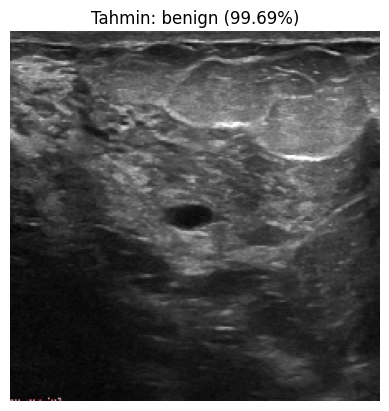

In [68]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()  # JPG, JPEG veya PNG dosyalarını yükle.

for img_name in uploaded.keys():
    # Görseli yükle ve VGG16 için hazırla
    img = image.load_img(img_name, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Özellik çıkarımı (VGG16 ile)
    feature = vgg_model.predict(img_array).flatten().reshape(1, -1)

    # SVM modeli ile tahmin
    pred_label_encoded = svm_model.predict(feature)[0]
    pred_label = y_encoder.inverse_transform([pred_label_encoded])[0]

    pred_proba = svm_model.predict_proba(feature).max() * 100

    # Sonucu görselleştir
    plt.figure()
    plt.imshow(img)
    plt.title(f"Tahmin: {pred_label} ({pred_proba:.2f}%)")
    plt.axis("off")
    plt.show()


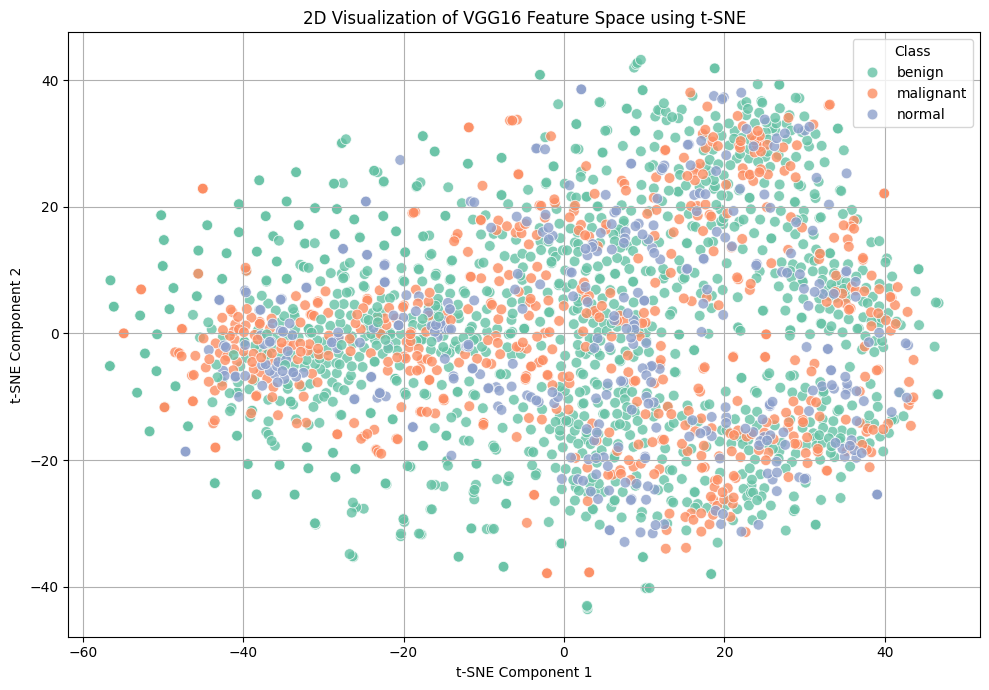

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Train ve test featurelarını birleştirme
X_all_feat = np.concatenate((X_train_feat, X_test_feat), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

#t-SNE aracılığıyla 2 boyuta indirgeniyor
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_all_feat)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_all,
    palette="Set2",
    s=60,
    alpha=0.8
)
plt.title("2D Visualization of VGG16 Feature Space using t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_model.fit(X_train_feat, y_train_enc)


SVC(C=10, probability=True)


SVM using VGG16 TEST METRICS:
Accuracy:  0.8087
Precision: 0.8083
Recall:    0.7440
F1-score:  0.7688
ROC AUC:   0.9306

🔬 Classification Report:
              precision    recall  f1-score   support

      benign       0.80      0.92      0.86        65
   malignant       0.88      0.68      0.76        31
      normal       0.75      0.63      0.69        19

    accuracy                           0.81       115
   macro avg       0.81      0.74      0.77       115
weighted avg       0.81      0.81      0.80       115



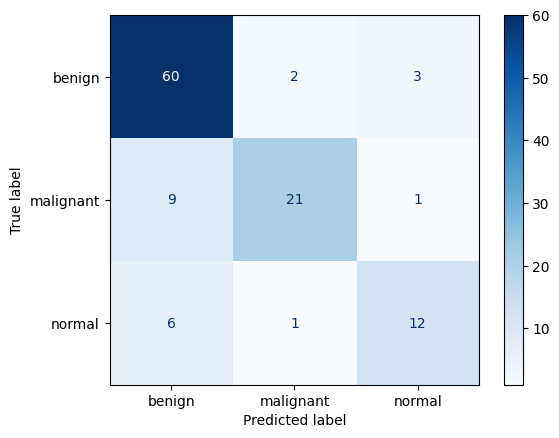

In [34]:
# Evaluate
y_pred = svm_model.predict(X_test_feat)
y_proba = svm_model.predict_proba(X_test_feat)

y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])
acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred, average='macro')
rec = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
roc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')

print("\nSVM using VGG16 TEST METRICS:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

# Classification report ve confusion matrix
print("\n🔬 Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=y_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()

###SVM WITHOUT VGG16 — Using Flattened Raw Pixel Data (64x64)


In [35]:
img_size = (64, 64)
batch_size = 32
dataset_path = "/content/breast_ultrasound_split"

In [36]:
def load_flattened_images(directory):
    X = []
    y = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if not os.path.isdir(class_dir):
            continue
        for img_name in tqdm(os.listdir(class_dir), desc=f"Loading {label}"):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = image.load_img(img_path, target_size=img_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize
                X.append(img_array.flatten())
                y.append(label)
            except:
                continue
    return np.array(X), np.array(y)

X_train_raw, y_train_raw = load_flattened_images(os.path.join(dataset_path, 'train'))
X_test_raw, y_test_raw = load_flattened_images(os.path.join(dataset_path, 'test'))


Loading normal: 100%|██████████| 19/19 [00:00<00:00, 144.79it/s]


In [37]:
y_encoder = LabelEncoder()
y_train_enc = y_encoder.fit_transform(y_train_raw)
y_test_enc = y_encoder.transform(y_test_raw)

In [38]:
svm_raw = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_raw.fit(X_train_raw, y_train_enc)


SVC(C=10, probability=True)


SVM (Raw Pixels) TEST METRICS:
Accuracy:  0.7043
Precision: 0.7101
Recall:    0.6239
F1-score:  0.6528
ROC AUC:   0.8393

Classification Report:
              precision    recall  f1-score   support

      benign       0.71      0.86      0.78        65
   malignant       0.65      0.48      0.56        31
      normal       0.77      0.53      0.62        19

    accuracy                           0.70       115
   macro avg       0.71      0.62      0.65       115
weighted avg       0.70      0.70      0.69       115



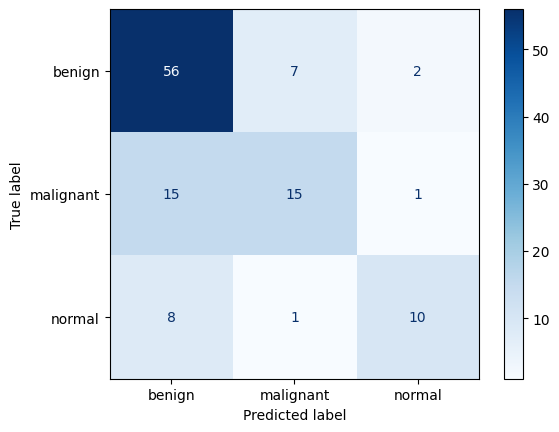

In [39]:
#Evaluate
y_pred_raw = svm_raw.predict(X_test_raw)
y_proba_raw = svm_raw.predict_proba(X_test_raw)

y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])

acc = accuracy_score(y_test_enc, y_pred_raw)
prec = precision_score(y_test_enc, y_pred_raw, average='macro')
rec = recall_score(y_test_enc, y_pred_raw, average='macro')
f1 = f1_score(y_test_enc, y_pred_raw, average='macro')
roc = roc_auc_score(y_test_bin, y_proba_raw, multi_class='ovr')

print("\nSVM (Raw Pixels) TEST METRICS:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_raw, target_names=y_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred_raw)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()

### ✅ LOGISTIC REGRESSION — Using Raw Pixel Data (64x64)


In [42]:
logreg_model = LogisticRegression(max_iter=1000, multi_class='ovr')
logreg_model.fit(X_train_raw, y_train_enc)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='ovr')


LOGISTIC REGRESSION TEST METRICS:
Accuracy:  0.5913
Precision: 0.5403
Recall:    0.4907
F1-score:  0.5050
ROC AUC:   0.6962

Classification Report:
              precision    recall  f1-score   support

      benign       0.64      0.77      0.70        65
   malignant       0.48      0.39      0.43        31
      normal       0.50      0.32      0.39        19

    accuracy                           0.59       115
   macro avg       0.54      0.49      0.50       115
weighted avg       0.57      0.59      0.57       115



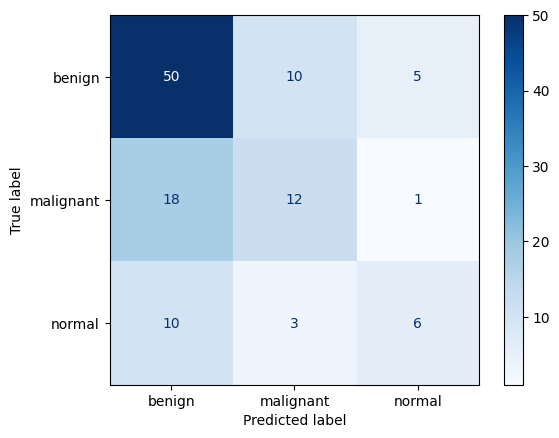

In [43]:
y_pred_logreg = logreg_model.predict(X_test_raw)
y_proba_logreg = logreg_model.predict_proba(X_test_raw)

y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])

acc = accuracy_score(y_test_enc, y_pred_logreg)
prec = precision_score(y_test_enc, y_pred_logreg, average='macro')
rec = recall_score(y_test_enc, y_pred_logreg, average='macro')
f1 = f1_score(y_test_enc, y_pred_logreg, average='macro')
roc = roc_auc_score(y_test_bin, y_proba_logreg, multi_class='ovr')

print("\nLOGISTIC REGRESSION TEST METRICS:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_logreg, target_names=y_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()

###RANDOM FOREST — With Hyperparameter Tuning and Feature Selection


In [44]:
# Feature Selection
selector = SelectKBest(mutual_info_classif, k=300)
X_train_sel = selector.fit_transform(X_train_raw, y_train_enc)
X_test_sel = selector.transform(X_test_raw)


In [45]:
#Grid Search for Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_sel, y_train_enc)
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits



 RANDOM FOREST TEST METRICS:
Accuracy:  0.6609
Precision: 0.6630
Recall:    0.5362
F1-score:  0.5590
ROC AUC:   0.7452

Classification Report:
              precision    recall  f1-score   support

      benign       0.67      0.86      0.76        65
   malignant       0.60      0.48      0.54        31
      normal       0.71      0.26      0.38        19

    accuracy                           0.66       115
   macro avg       0.66      0.54      0.56       115
weighted avg       0.66      0.66      0.64       115



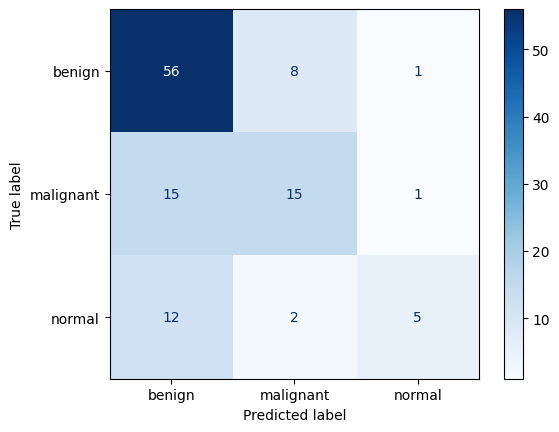

In [57]:
#Evaluate
y_pred_rf = best_rf.predict(X_test_sel)
y_proba_rf = best_rf.predict_proba(X_test_sel)
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])

acc = accuracy_score(y_test_enc, y_pred_rf)
prec = precision_score(y_test_enc, y_pred_rf, average='macro')
rec = recall_score(y_test_enc, y_pred_rf, average='macro')
f1 = f1_score(y_test_enc, y_pred_rf, average='macro')
roc = roc_auc_score(y_test_bin, y_proba_rf, multi_class='ovr')

print("\n RANDOM FOREST TEST METRICS:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_rf, target_names=y_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()


### ✅ PCA + NAIVE BAYES — Improved for Breast Ultrasound


In [47]:
#Featuresları standardize etme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [48]:
#PCA uygulama
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [49]:
nb_model = GaussianNB()
b_model = nb_model.fit(X_train_pca, y_train_enc)


PCA + NAIVE BAYES TEST METRICS:
Accuracy:  0.5652
Precision: 0.5769
Recall:    0.6297
F1-score:  0.5561
ROC AUC:   0.8014

Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.43      0.57        65
   malignant       0.51      0.77      0.62        31
      normal       0.37      0.68      0.48        19

    accuracy                           0.57       115
   macro avg       0.58      0.63      0.56       115
weighted avg       0.68      0.57      0.57       115



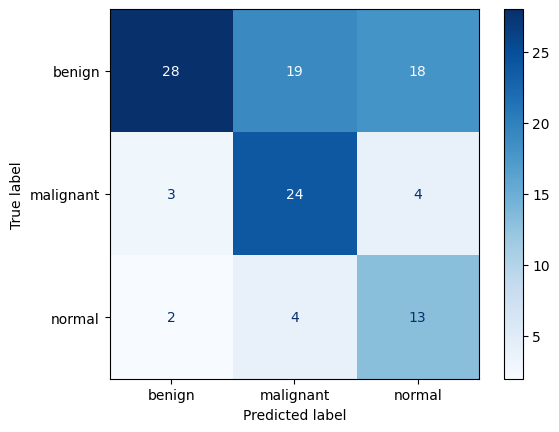

In [50]:
#Evaluate
y_pred = nb_model.predict(X_test_pca)
y_proba = nb_model.predict_proba(X_test_pca)
y_test_bin = label_binarize(y_test_enc, classes=[0, 1, 2])

acc = accuracy_score(y_test_enc, y_pred)
prec = precision_score(y_test_enc, y_pred, average='macro')
rec = recall_score(y_test_enc, y_pred, average='macro')
f1 = f1_score(y_test_enc, y_pred, average='macro')
roc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')

print("\nPCA + NAIVE BAYES TEST METRICS:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=y_encoder.classes_))

cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(cmap="Blues")
plt.show()